# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.manifold import MDS
from factor_analyzer import FactorAnalyzer
import networkx as nx
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go

# Data

In [227]:
# Load in dynamics data
df_daily = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_3_data_analysis/02_analysis/df_good.csv')

# Run 1
r1_on = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/run_1/run1_battery_onB.csv')
r1_off = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/run_1/run1_battery_offB.csv')
r1_battery = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/run_1/run1_battery_onOff.csv')

# Run 2
r2_on = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/run_2/run2_battery_onB.csv')
r2_off = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/run_2/run2_battery_offB.csv')
r2_battery = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/run_2/run2_battery_onOff.csv')

# Qualtrics
q1 = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/qualtrics_summary.csv')
q2 = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/qualtrics_demo_plus.csv')

## Process daily data

In [228]:
# Create daily_natLang dataframe with natural language columns
daily_natLang = df_daily[['PID', 'trial_date', 'day', 'cohort',
                         'sr_DAILY_goal1_set', 'sr_DAILY_goal2_set', 'sr_DAILY_past24_gapCause',
                         'sr_IDEAL_values_monthly1', 'sr_IDEAL_values_monthly2', 'sr_IDEAL_values_monthly3',
                         'sr_MONTHLY_goal_set1', 'sr_MONTHLY_goal_set2',
                         'sr_WEEKLY_goal_set1', 'sr_WEEKLY_goal_set2']].copy()

daily_natLang.head()


,PID,trial_date,day,cohort,sr_DAILY_goal1_set,sr_DAILY_goal2_set,sr_DAILY_past24_gapCause,sr_IDEAL_values_monthly1,sr_IDEAL_values_monthly2,sr_IDEAL_values_monthly3,sr_MONTHLY_goal_set1,sr_MONTHLY_goal_set2,sr_WEEKLY_goal_set1,sr_WEEKLY_goal_set2
0,0151d9f1-1644-4437-805e-02f5e244a690,2023-01-30,1,cohort 2,Finish anthropology readings,Brainstorm and write more ideas for my psychol...,100_0,Punctuality,Generosity,Organization,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,Have a good understanding of biology concepts ...,Improving my sleep schedule
1,0151d9f1-1644-4437-805e-02f5e244a690,2023-01-31,2,cohort 2,Keep working on psych paper,Finish chem prelab,100_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-01,3,cohort 2,Keep working on psych paper,Review bio questions,100_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-02,4,cohort 2,Finish and hand in psych rough draft,Create quick bio lecture notes,100_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-03,5,cohort 2,Practice biology FSG questions,Catch up on anthropology readings,100_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [229]:
daily_natLang.sr_DAILY_past24_gapCause.value_counts()

sr_DAILY_past24_gapCause
100_0                1807
50_50                1225
90_10                 879
80_20                 834
70_30                 657
60_40                 581
40_60                 507
30_70                 500
20_80                 365
0_100                 281
10_90                 237
100_0 100_0             2
60_40 60_40             1
0_100 0_100             1
90_10 90_10 90_10       1
20_80 20_80             1
40_60 20_80             1
90_10 70_30             1
30_70 60_40             1
70_30 70_30             1
Name: count, dtype: int64

In [230]:
# Convert task times to minutes after 5am and rename columns
time_cols = {
    'task_motivation_time': 'task_motivation_min_after_5am',
    'task_gng_time': 'task_gng_min_after_5am', 
    'task_nback_time': 'task_nback_min_after_5am',
    'task_spatialSpan_tod': 'task_spatialSpan_min_after_5am'
}

for old_col, new_col in time_cols.items():
    # Convert time strings to datetime, handle any invalid formats
    df_daily[new_col] = pd.to_datetime(df_daily[old_col], format='%H:%M:%S', errors='coerce')
    
    # Calculate minutes after 5am
    df_daily[new_col] = ((df_daily[new_col].dt.hour - 5) * 60 + 
                         df_daily[new_col].dt.minute)
    
    # Handle times before 5am (negative values)
    df_daily.loc[df_daily[new_col] < 0, new_col] = df_daily.loc[df_daily[new_col] < 0, new_col] + 24*60
    
    # Drop old column
    df_daily = df_daily.drop(columns=[old_col])


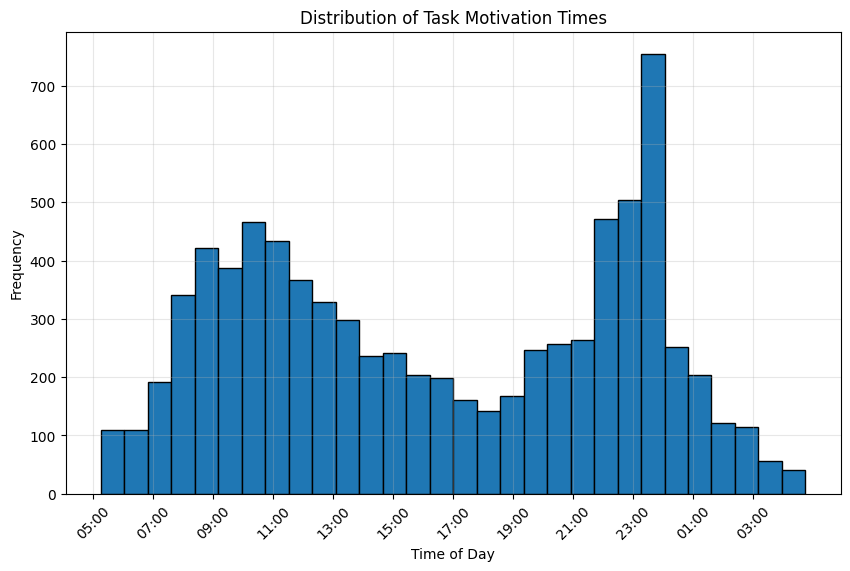

In [231]:
# Plot histogram of time subjects start tasks
# Convert minutes after 5am to actual times for x-axis labels
plt.figure(figsize=(10, 6))
plt.hist(df_daily.task_motivation_min_after_5am, bins=30, edgecolor='black')
plt.title('Distribution of Task Motivation Times')
plt.xlabel('Time of Day')
plt.ylabel('Frequency')

# Get current axis
ax = plt.gca()

# Set x-ticks every 2 hours (120 minutes)
xticks = np.arange(0, 24*60, 120)
ax.set_xticks(xticks)

# Convert minutes after 5am to time strings
def mins_to_time(mins):
    hours = ((mins // 60) + 5) % 24  # Add 5 hours and wrap around 24
    return f'{int(hours):02d}:00'

ax.set_xticklabels([mins_to_time(x) for x in xticks], rotation=45)
plt.grid(True, alpha=0.3)

In [232]:
# Rename task_nback_mode to task_nback_choseHard
df_daily = df_daily.rename(columns={'task_nback_mode': 'task_nback_choseHard'})

# Map 'hard' to 1 and 'easy' to 0
df_daily['task_nback_choseHard'] = df_daily['task_nback_choseHard'].map({'hard': 1, 'easy': 0})

In [233]:
# Convert task_hanoi_solved from boolean to numeric (1/0), preserving NaN values
df_daily['task_hanoi_solved'] = df_daily['task_hanoi_solved'].map({True: 1, False: 0})

In [234]:
# Get list of numeric columns
numeric_cols = df_daily.select_dtypes(include=['int64', 'float64']).columns

# Add back PID column
cols_to_keep = list(numeric_cols) + ['PID']

# Drop duplicates to get unique columns
cols_to_keep = list(dict.fromkeys(cols_to_keep))

# Keep only specified columns
df_daily = df_daily[cols_to_keep]

In [235]:
# Drop day_of_week column
df_daily = df_daily.drop('day_of_week', axis=1)

# Group by PID and calculate mean for all numeric columns
df_daily_means = df_daily.groupby('PID').mean().reset_index()

# Prepend 'daily_' to all column names except PID
rename_dict = {col: f'daily_{col}' for col in df_daily_means.columns if col != 'PID'}
df_daily_means = df_daily_means.rename(columns=rename_dict)

In [236]:
df_daily_means.head()

,PID,daily_affect_neg_angry,daily_affect_neg_ashamed,daily_affect_neg_bored,daily_affect_neg_depressed,daily_affect_neg_embarrassed,daily_affect_neg_frustrated,daily_affect_neg_guilty,daily_affect_neg_lazy,daily_affect_neg_lonelyIsolated,...,daily_passive_sk_device_total_usage_stickers,daily_passive_sk_device_total_usage_travel,daily_passive_sk_device_total_usage_utilities,daily_passive_sk_device_total_usage_weather,daily_passive_sk_calls_inOut_ratio,daily_passive_sk_messages_inOut_ratio,daily_task_motivation_min_after_5am,daily_task_gng_min_after_5am,daily_task_nback_min_after_5am,daily_task_spatialSpan_min_after_5am
0,0151d9f1-1644-4437-805e-02f5e244a690,1.297619,1.226190,2.345238,1.357143,1.238095,1.773810,1.178571,2.214286,1.035714,...,0.0,398.882353,136.682353,3.188235,1.909091,1.392803,196.452381,206.083333,208.216867,202.916667
1,02f48bee-6e86-437c-9394-10ae57dadd14,3.000000,2.974684,2.949367,2.962025,2.962025,2.974684,2.974684,2.962025,2.962025,...,0.0,0.788235,78.729412,2.976471,3.842857,2.488758,1082.687500,1147.181818,1138.500000,1151.649351
2,0501ba67-3406-4779-aff1-878a0e9f7885,2.126582,1.278481,2.658228,2.354430,1.278481,3.189873,2.050633,3.278481,2.481013,...,0.0,102.988235,945.105882,18.047059,3.100000,3.782609,695.605263,848.753247,894.916667,837.786667
3,06af7782-cd70-4938-8e67-b6d98b34b665,1.905405,1.689189,2.500000,1.959459,1.527027,2.027027,1.932432,3.040541,1.945946,...,0.0,45.811765,53.000000,21.729412,1.788889,1.666700,1011.364865,1006.890909,939.428571,1020.027397
4,075f7c4e-edea-4d64-8844-f046a1beb770,2.384615,1.166667,1.051282,3.423077,1.038462,2.743590,1.256410,3.858974,1.230769,...,0.0,92.870588,87.670588,2.164706,2.014875,1.738056,548.649351,631.558442,651.693333,686.337662


## Process battery data

In [340]:
# Process r1_battery
onb_cols_r1 = [col for col in r1_battery.columns if col.startswith('onB_')]
offb_cols_r1 = [col for col in r1_battery.columns if col.startswith('offB_')]

onb_stripped_r1 = [col.replace('onB_', '') for col in onb_cols_r1]
offb_stripped_r1 = [col.replace('offB_', '') for col in offb_cols_r1]

common_cols_r1 = set(onb_stripped_r1).intersection(set(offb_stripped_r1))

avg_df_r1 = pd.DataFrame()
id_cols = ['ParticipantIdentifier']
avg_df_r1[id_cols] = r1_battery[id_cols]

for col in common_cols_r1:
    onb_col = 'onB_' + col
    offb_col = 'offB_' + col
    
    onb_vals = r1_battery[onb_col]
    offb_vals = r1_battery[offb_col]
    
    avg_df_r1[col + '_avg'] = pd.DataFrame({
        'onb': onb_vals,
        'offb': offb_vals
    }).mean(axis=1, skipna=True)

# Add cohort column
avg_df_r1['cohort'] = 1

# Process r2_battery
onb_cols_r2 = [col for col in r2_battery.columns if col.startswith('onB_')]
offb_cols_r2 = [col for col in r2_battery.columns if col.startswith('offB_')]

onb_stripped_r2 = [col.replace('onB_', '') for col in onb_cols_r2]
offb_stripped_r2 = [col.replace('offB_', '') for col in offb_cols_r2]

common_cols_r2 = set(onb_stripped_r2).intersection(set(offb_stripped_r2))

avg_df_r2 = pd.DataFrame()
avg_df_r2[id_cols] = r2_battery[id_cols]

for col in common_cols_r2:
    onb_col = 'onB_' + col
    offb_col = 'offB_' + col
    
    onb_vals = r2_battery[onb_col]
    offb_vals = r2_battery[offb_col]
    
    avg_df_r2[col + '_avg'] = pd.DataFrame({
        'onb': onb_vals,
        'offb': offb_vals
    }).mean(axis=1, skipna=True)

# Add cohort column
avg_df_r2['cohort'] = 2

# Combine both dataframes
df_battery = pd.concat([avg_df_r1, avg_df_r2], ignore_index=True)

In [341]:
# Remove effort avoidance task score column
df_battery = df_battery.drop('effort_avoidance_task_score_avg', axis=1)

# remove perfectly correlated columns
df_battery = df_battery.drop('probabilistic_selc_task_positive_learning_bias_avg', axis=1)
df_battery = df_battery.drop('cognitive_ref_task_intuitive_prop_avg', axis=1)
df_battery = df_battery.drop('shift_task_num_trials_avg', axis=1)

In [342]:
# Rename task columns
task_cols = [
    'attention_network_task_orienting_rt_avg',
    'attention_network_task_acc_avg', 
    'simon_task_congruent_avg_rt_avg',
    'psychomotor_vigilance_score_avg',
    'simple_reaction_time_task_avg_rt_avg',
    'go_nogo_task_dprime_avg',
    'stroop_task_con_avg_avg',
    'simon_task_incongruent_seq_acc_avg',
    'probabilistic_selc_task_missed_percent_avg',
    'attention_network_task_incongruent_rt_avg',
    'cognitive_estimation_task_score_avg',
    'keep_track_task_score_avg',
    #'probabilistic_selc_task_positive_learning_bias_avg',
    'berlin_numeracy_task_score_avg',
    'shift_task_std_rt_avg',
    'attention_network_task_post_error_slowing_avg',
    'ravens_task_score_avg',
    'TOL_task_num_correct_avg',
    'attention_network_task_congruent_rt_avg',
    'TOL_task_planning_time_avg',
    'simon_task_rt_avg',
    'stroop_task_incon_avg_avg',
    'information_sampling_task_fixed_win_total_points_avg',
    #'shift_task_num_trials_avg',
    'probabilistic_selc_task_log_ll_avg',
    'shift_task_conceptual_responses_avg',
    'simon_task_missed_percent_avg',
    'TOL_task_avg_move_time_avg',
    'information_sampling_task_fixed_win_acc_avg',
    'jdm_classics_task_score_avg',
    'go_nogo_task_bias_avg',
    'attention_network_task_neutral_rt_avg',
    'semantic_verbal_fluency_task_total_avg',
    'TOL_task_num_extra_moves_avg',
    'attention_network_task_conflict_rt_avg',
    'cognitive_ref_task_correct_prop_avg',
    'attention_network_task_alerting_acc_avg',
    'probabilistic_selc_task_overall_test_acc_avg',
    'attention_network_task_missed_percent_avg',
    'information_sampling_task_decreasing_win_acc_avg',
    'semantic_verbal_fluency_task_f_words_num_avg',
    'TOL_task_num_optimal_solutions_avg',
    'simple_reaction_time_task_missed_percent_avg',
    'attention_network_task_orienting_acc_avg',
    'simon_task_congruent_seq_rt_avg',
    'shift_task_acc_avg',
    'simon_task_congruent_acc_avg',
    'semantic_verbal_fluency_task_animals_words_num_avg',
    'information_sampling_task_decreasing_win_total_points_avg',
    'simon_task_post_error_slowing_avg',
    'probabilistic_selc_task_value_sensitivity_avg',
    'semantic_verbal_fluency_task_s_words_num_avg',
    'simon_task_incongruent_acc_avg',
    'attention_network_task_alerting_rt_avg',
    'shift_task_fail_to_maintain_set_avg',
    'simon_task_acc_avg',
    'two_stage_task_missed_percent_avg',
    'stroop_task_incon_sd_avg',
    'holt_laury_task_score_avg',
    'stroop_task_con_sd_avg',
    'shift_task_missed_percent_avg',
    'plus_minus_task_score_avg',
    'probabilistic_selc_task_num_trials_avg',
    'shift_task_avg_rt_avg',
    'two_stage_task_avg_rt_avg',
    'stroop_task_effect_avg',
    'TOL_task_weighted_performance_score_avg',
    #'cognitive_ref_task_intuitive_prop_avg',
    'semantic_verbal_fluency_task_jobs_words_num_avg',
    'attention_network_task_conflict_acc_avg',
    'stroop_task_accuracy_avg',
    #'effort_avoidance_task_score_avg', # data seems to be either 200 or nan
    'simon_task_incongruent_avg_rt_avg'
]

# Rename trait columns 
trait_cols = [
    'maximizing_scale_dec_difficulty_avg',
    'food_fruitveg_score_avg',
    'competetiveness_index_enjoyment_avg',
    'secular_measure_work_ethic_cli_avg',
    'maximizing_scale_MTS_avg',
    'grit_scale_score_avg',
    'boredom_proneness_score_avg',
    'propensity_to_plan_tlr_avg',
    'life_orientation_test_score_avg',
    'leisure_time_activity_score_avg',
    'trait_hedonic_capacity_score_avg',
    'brief_self_control_score_avg',
    'trait_emotional_intelligence_score_avg',
    'secular_measure_work_ethic_iwm_avg',
    'bsss_exp_seek_avg',
    'propensity_to_plan_msr_avg',
    'general_self_efficacy_score_avg',
    'ambition_score_avg',
    'domain_gap_avg',
    'mindful_attention_avg',
    'competetiveness_index_contentiousness_avg',
    'con_hex_score_avg',
    'bsss_boredom_sus_avg',
    'bsss_overall_avg',
    'maximizing_scale_overall_avg',
    'maximizing_scale_alt_search_avg',
    'bsss_disinhibition_avg',
    'bsss_thrill_avg',
    'future_time_perspective_score_avg',
    'propensity_to_plan_tsr_avg',
    'trait_robustness_of_self_confidence_score_avg',
    'maximizing_scale_high_standards_avg',
    'need_for_cognition_score_avg',
    'food_fat_score_avg',
    'grit_scale_PE_avg',
    'secular_measure_work_ethic_score_avg',
    'maximizing_scale_SMTS_avg',
    'secular_measure_work_ethic_moral_avg',
    'grit_scale_CI_avg',
    'competetiveness_index_enjoyment_overall_avg',
    'propensity_to_plan_mlr_avg',
    'social_des_score_avg',
    'PANAS_positive_affect_avg',
    'PANAS_negative_affect_avg'
]

# Rename outcome columns
outcome_cols = [
    'DASS_stress_avg',
    'k6_survey_score_avg', 
    'DASS_anxiety_avg',
    'bmi_avg',
    'harmony_score_avg',
    'well_being_avg',
    'grades_avg_avg',
    'perceived_stress_score_avg',
    'rosenberg_SES_score_avg',
    'sub_happy_score_avg',
    'flourishing_score_avg',
    'qol_score_avg',
    'DASS_depression_avg',
    'DASS_overall_avg',
    'sat_life_score_avg'
]

# Add prefixes
df_battery = df_battery.rename(columns={col: f'battery_task_{col}' for col in task_cols})
df_battery = df_battery.rename(columns={col: f'battery_trait_{col}' for col in trait_cols})
df_battery = df_battery.rename(columns={col: f'battery_outcome_{col}' for col in outcome_cols})

# Reorder columns
id_cols = ['ParticipantIdentifier', 'cohort']
other_cols = sorted([col for col in df_battery.columns if col not in id_cols])
df_battery = df_battery[id_cols + other_cols]

In [343]:
# Rename ParticipantIdentifier to PID
df_battery = df_battery.rename(columns={'ParticipantIdentifier': 'PID'})

# Update id_cols list to reflect the change
id_cols = ['PID', 'cohort']
other_cols = sorted([col for col in df_battery.columns if col not in id_cols])
df_battery = df_battery[id_cols + other_cols]

## Process qualtrics data

In [313]:
# Remove columns between Finished and consent_prescreen
cols_to_drop = ['EndDate', 'Status', 'IPAddress', 'Progress',
                'StartDate', 'Duration..in.seconds.',
                'Finished', 'RecordedDate', 'ResponseId',
                'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
                'ExternalReference', 'LocationLatitude', 'LocationLongitude',
                'DistributionChannel', 'UserLanguage', 'consent_1', 'consent_2',
                'consent_3', 'consent_4', 'consent_sonaID', 'consent_prescreen',
                'social_media_1', 'social_media_2', 'social_media_3', 'social_media_4',
                'weight_dec20', 'standardized_tests_1', 'standardized_tests_2',
                'standardized_tests_3'
                ]

q2 = q2.drop(columns=cols_to_drop)

In [314]:
# Convert student_id to integer
#q1['student_id'] = pd.to_numeric(q1['student_id'], errors='coerce').astype('Int64')
q2['student_id'] = pd.to_numeric(q2['student_id'], errors='coerce').astype('Int64')

In [177]:
# Prepend 'id_' to identifier columns
id_cols = ['cohort', 'onOff', 'ParticipantIdentifier', 'student_id']
#q1 = q1.rename(columns={col: f'id_{col}' for col in id_cols})
q2 = q2.rename(columns={col: f'id_{col}' for col in id_cols})

In [178]:
# Rename criminality columns
criminality_cols = ['criminality.1_1', 'criminality.1_2',
            'criminality.1_3', 'criminality.1_4', 'criminality.1_5',
            'criminality.1_6', 'criminality.1_7', 'criminality.1_8'
]
 
renamed_criminality_cols = [
    "criminality_charged_with_DUI",
    "criminality_charged_with_misdemeanor",
    "criminality_convicted_of_misdemeanor",
    "criminality_charged_with_felony",
    "criminality_convicted_of_felony",
    "criminality_assigned_community_service",
    "criminality_assigned_a_parole_officer",
    "criminality_incarcerated"
]

#q1 = q1.rename(columns=dict(zip(criminality_cols, renamed_criminality_cols)))
q2 = q2.rename(columns=dict(zip(criminality_cols, renamed_criminality_cols)))

# Rename and reformat height and weight columns
# Convert height from feet/inches to cm
#q1['height_cm'] = (q1['height.1_1'] * 30.48) + (q1['height.2_1'] * 2.54)
q2['height_cm'] = (q2['height.1_1'] * 30.48) + (q2['height.2_1'] * 2.54)

# Drop original height columns
#q1 = q1.drop(columns=['height.1_1', 'height.2_1'])
q2 = q2.drop(columns=['height.1_1', 'height.2_1'])

# Convert weight from pounds to kg
#q1['weight_kg'] = q1['weight'] * 0.453592
q2['weight_kg'] = q2['weight'] * 0.453592

# Drop original weight column
#q1 = q1.drop(columns=['weight'])
q2 = q2.drop(columns=['weight'])

In [179]:
# Prepend 'demo_' to demographic columns
demo_cols = ['age', 'gender', 'hispanic', 'ethnicity', 'education', 
            'father_education', 'mother_education', 'marital_status',
            'children_1', 'employment_status', 'social_media_time',
            'income', 'parents_income', 'net_worth', 'parents_net_worth',
            'housing_status', 'criminality_charged_with_DUI', 'criminality_charged_with_misdemeanor',
            'criminality_convicted_of_misdemeanor', 'criminality_charged_with_felony',
            'criminality_convicted_of_felony', 'criminality_assigned_community_service',
            'criminality_assigned_a_parole_officer', 'criminality_incarcerated',
            'macarthur_sss', 'macarthur_sss_parent',
            'job', 'accomp_career', 'accomp_personal',
            'weight_kg', 'height_cm',]

#q1 = q1.rename(columns={col: f'demo_{col}' for col in demo_cols})
q2 = q2.rename(columns={col: f'demo_{col}' for col in demo_cols})

# Prepend 'academic_' to academic columns
academic_cols = [
    'sat_score','gre_score_verbal', 'gre_score_quant',
    'lsat_score', 'gpa_highschool', 'gpa_undergrad', 'student_status',
    'semesters_complete', 'gpa_current', 'performance_compare_1',
    'classes_number', 'X1_class_name', 'X1_grade_goal', 'X1_grade_predict',
    'X2_class_name', 'X2_grade_goal', 'X2_grade_predict',
    'X3_class_name', 'X3_grade_goal', 'X3_grade_predict',
    'X4_class_name', 'X4_grade_goal', 'X4_grade_predict',
    'X5_class_name', 'X5_grade_goal', 'X5_grade_predict',
    ]

#q1 = q1.rename(columns={col: f'academic_{col}' for col in academic_cols})
q2 = q2.rename(columns={col: f'academic_{col}' for col in academic_cols})

In [180]:
# Prepend 'academic_' to academic columns
academic_cols = [
    'sat_score','gre_score_verbal', 'gre_score_quant',
    'lsat_score', 'gpa_highschool', 'gpa_undergrad', 'student_status',
    'semesters_complete', 'gpa_current', 'performance_compare_1',
    'classes_number', 'X1_class_name', 'X1_grade_goal', 'X1_grade_predict',
    'X2_class_name', 'X2_grade_goal', 'X2_grade_predict',
    'X3_class_name', 'X3_grade_goal', 'X3_grade_predict',
    'X4_class_name', 'X4_grade_goal', 'X4_grade_predict',
    'X5_class_name', 'X5_grade_goal', 'X5_grade_predict',
    ]

#q1 = q1.rename(columns={col: f'academic_{col}' for col in academic_cols})
q2 = q2.rename(columns={col: f'academic_{col}' for col in academic_cols})

In [181]:
# Drop grade_goal_1, grade_goal_2, grade_predict_1, grade_predict_2 columns
# cols_to_drop = [col for col in q1.columns if any(x in col for x in ['grade_goal_1', 'grade_goal_2', 'grade_predict_1', 'grade_predict_2'])]
# q1 = q1.drop(columns=cols_to_drop)
cols_to_drop = [col for col in q2.columns if any(x in col for x in ['grade_goal_1', 'grade_goal_2', 'grade_predict_1', 'grade_predict_2'])]
q2 = q2.drop(columns=cols_to_drop)

# Rename grade_goal_3 and grade_predict_3 columns to remove _3
# rename_dict = {col: col.replace('_3', '') for col in q1.columns if 'grade_goal_3' in col or 'grade_predict_3' in col}
# q1 = q1.rename(columns=rename_dict)
rename_dict = {col: col.replace('_3', '') for col in q2.columns if 'grade_goal_3' in col or 'grade_predict_3' in col}
q2 = q2.rename(columns=rename_dict)

In [186]:
# Recode gender
gender_map = {
    1: 'male',
    2: 'female', 
    3: 'other'
}
q2['demo_gender'] = q2['demo_gender'].map(gender_map)

# Recode ethnicity 
ethnicity_map = {
    1: 'White',
    2: 'Black or African American',
    3: 'American Indian or Alaska Native', 
    4: 'Asian',
    5: 'Native Hawaiian or Pacific Islander',
    6: 'Other'
}
q2['demo_ethnicity'] = q2['demo_ethnicity'].map(ethnicity_map)

# Recode education levels
education_map = {
    1: 'Less than a high school diploma',
    2: 'High school degree or equivalent (e.g. GED)',
    3: 'Some college, no degree',
    4: 'Associate degree (e.g. AA, AS)',
    5: "Bachelor's degree (e.g. BA, BS)",
    6: "Master's degree (e.g. MA, MS, MEd)",
    7: 'Doctorate or professional degree (e.g. MD, DDS, PhD)'
}

# Apply education mapping to all education columns
q2['demo_education'] = q2['demo_education'].map(education_map)
q2['demo_father_education'] = q2['demo_father_education'].map(education_map) 
q2['demo_mother_education'] = q2['demo_mother_education'].map(education_map)

In [187]:
# Recode marital status
marital_status_map = {
    1: "Single (never married)",
    2: "Married, or in a domestic partnership",
    3: "Remarried, or in a domestic partnership after divorce", 
    4: "Widowed",
    5: "Divorced",
    6: "Separated"
}
q2['demo_marital_status'] = q2['demo_marital_status'].map(marital_status_map)

# Rename demo_children_1 to num_children
q2 = q2.rename(columns={'demo_children_1': 'demo_num_children'})

# Recode employment status
# Recode employment status
employment_status_map = {
    1: "Employed full time (40 or more hours per week)",
    2: "Employed part time (up to 39 hours per week)", 
    3: "Unemployed and currently looking for work",
    4: "Unemployed not currently looking for work",
    5: "Student",
    6: "Retired",
    7: "Homemaker",
    8: "Self-employed",
    9: "Unable to work"
}
q2['demo_employment_status'] = q2['demo_employment_status'].map(employment_status_map)

# Rename demo_social_media_time to social_media_time
q2 = q2.rename(columns={'demo_social_media_time': 'demo_social_media_time_daily_minutes'})

# Recode demo_income
income_map = {
    1: "Less than $10,000",
    2: "$10,000 to $19,999", 
    3: "$20,000 to $29,999",
    4: "$30,000 to $39,999",
    5: "$40,000 to $49,999",
    6: "$50,000 to $59,999",
    7: "$60,000 to $69,999",
    8: "$70,000 to $79,999",
    9: "$80,000 to $89,999",
    10: "$90,000 to $99,999",
    11: "$100,000 to $149,999",
    12: "$150,000 to $249,999",
    13: "$250,000 or more"
}
q2['demo_income'] = q2['demo_income'].map(income_map)

# Recode demo_parents_income
parents_income_map = {
    1: "Less than $10,000",
    2: "$10,000 to $19,999",
    3: "$20,000 to $29,999", 
    4: "$30,000 to $39,999",
    5: "$40,000 to $49,999",
    6: "$50,000 to $59,999",
    7: "$60,000 to $69,999",
    8: "$70,000 to $79,999",
    9: "$80,000 to $89,999",
    10: "$90,000 to $99,999",
    11: "$100,000 to $149,999",
    12: "$150,000 to $249,999",
    13: "$250,000 to $399,999",
    14: "$400,000 or more",
    15: "n/a"
}
q2['demo_parents_income'] = q2['demo_parents_income'].map(parents_income_map)

# Recode demo_net_worth
net_worth_map = {
    1: "Less than $10,000",
    2: "$10,000 to $19,999",
    3: "$20,000 to $29,999",
    4: "$30,000 to $39,999", 
    5: "$40,000 to $49,999",
    6: "$50,000 to $59,999",
    7: "$60,000 to $69,999",
    8: "$70,000 to $79,999",
    9: "$80,000 to $89,999",
    10: "$90,000 to $99,999",
    11: "$100,000 to $149,999",
    12: "$150,000 to $249,999",
    13: "$250,000 to $499,999",
    14: "$500,000 to $1 million",
    15: "$1 million to $2 million",
    16: "$2 million to $5 million",
    17: "$5 million or more"
}
q2['demo_net_worth'] = q2['demo_net_worth'].map(net_worth_map)

# Recode demo_parents_net_worth
parents_net_worth_map = {
    1: "Less than $10,000",
    2: "$10,000 to $19,999", 
    3: "$20,000 to $29,999",
    4: "$30,000 to $39,999",
    5: "$40,000 to $49,999",
    6: "$50,000 to $59,999",
    7: "$60,000 to $69,999",
    8: "$70,000 to $79,999",
    9: "$80,000 to $89,999",
    10: "$90,000 to $99,999",
    11: "$100,000 to $149,999",
    12: "$150,000 to $249,999",
    13: "$250,000 to $499,999",
    14: "$500,000 to $1 million",
    15: "$1 million to $2 million",
    16: "$2 million to $5 million",
    17: "$5 million or more",
    18: "n/a"
}
q2['demo_parents_net_worth'] = q2['demo_parents_net_worth'].map(parents_net_worth_map)

# Recode demo_housing_status
housing_status_map = {
    1: "Own with no mortgage",
    2: "Rent - Alone", 
    3: "Live with family",
    4: "Own with mortgage",
    5: "Other",
    6: "Student Housing - Alone",
    7: "Student Housing - Roommate",
    8: "Rent - Couple",
    9: "Rent - Roommates"
}
q2['demo_housing_status'] = q2['demo_housing_status'].map(housing_status_map)


In [188]:
# Create version of q2 with only id_, demo_, and academic_ columns
qualtrics = q2.loc[:, q2.columns.str.startswith(('id_', 'demo_', 'academic_'))]

In [189]:
qualtrics.columns

Index(['id_cohort', 'id_onOff', 'id_ParticipantIdentifier', 'id_student_id',
       'demo_age', 'demo_gender', 'demo_hispanic', 'demo_ethnicity',
       'demo_education', 'demo_father_education', 'demo_mother_education',
       'demo_marital_status', 'demo_num_children', 'demo_employment_status',
       'demo_social_media_time_daily_minutes', 'demo_income',
       'demo_parents_income', 'demo_net_worth', 'demo_parents_net_worth',
       'demo_housing_status', 'demo_criminality_charged_with_DUI',
       'demo_criminality_charged_with_misdemeanor',
       'demo_criminality_convicted_of_misdemeanor',
       'demo_criminality_charged_with_felony',
       'demo_criminality_convicted_of_felony',
       'demo_criminality_assigned_community_service',
       'demo_criminality_assigned_a_parole_officer',
       'demo_criminality_incarcerated', 'demo_macarthur_sss',
       'demo_macarthur_sss_parent', 'demo_job', 'demo_accomp_career',
       'demo_accomp_personal', 'academic_sat_score',
       'a

In [147]:
[col for col in q2.columns.tolist() if not (col.startswith('id_') or col.startswith('demo_') or col.startswith('academic_') or '_interact_' in col)]

['X1_grade_goal',
 'X1_grade_predict',
 'X2_grade_goal',
 'X2_grade_predict',
 'X3_grade_goal',
 'X3_grade_predict',
 'X4_grade_goal',
 'X4_grade_predict',
 'X5_grade_goal',
 'X5_grade_predict',
 'overall_success_pre_1',
 'ib_domain_goal_Diet',
 'ib_domain_goal_Exercise',
 'ib_domain_goal_MentalPersonal_Health',
 'ib_domain_goal_Medical_Health',
 'ib_domain_goal_Sleep',
 'ib_domain_goal_Alcohol_drug',
 'ib_domain_goal_Online',
 'ib_domain_goal_Phone',
 'ib_domain_goal_Video games',
 'ib_domain_goal_Reading_leisure',
 'ib_domain_goal_SocialMedia',
 'ib_domain_goal_Sports_playing',
 'ib_domain_goal_TV_Streaming',
 'ib_domain_goal_Family',
 'ib_domain_goal_Friends',
 'ib_domain_goal_Partner',
 'ib_domain_goal_Social_life',
 'ib_domain_goal_Hobby',
 'ib_domain_goal_Housework',
 'ib_domain_goal_Cooking',
 'ib_domain_goal_Work_School',
 'ib_domain_goal_Environment',
 'ib_domain_goal_Culture',
 'ib_domain_goal_Learning',
 'ib_domain_goal_Self-Improvement',
 'ib_domain_goal_Volunteering',
 'ib

# Analysis

In [344]:
# Create task dataframe with cognitive/behavioral task measures
task_cols = [col for col in df_battery.columns if any(x in col for x in ['task_'])]
task_df = df_battery[['PID'] + task_cols].copy()

# Create survey dataframe with questionnaire/survey measures 
survey_cols = [col for col in df_battery.columns if any(x in col for x in ['trait_'])]
survey_df = df_battery[['PID'] + survey_cols].copy()

# Create outcome dataframe with wellbeing/functioning measures
outcome_cols = [col for col in df_battery.columns if any(x in col for x in ['outcome_'])]
outcome_df = df_battery[['PID'] + outcome_cols].copy()


In [345]:
# Create lists of columns by type
survey_columns = [col for col in df_battery.columns if 'trait_' in col]
task_columns = [col for col in df_battery.columns if 'task_' in col] 
outcome_columns = [col for col in df_battery.columns if 'outcome_' in col]

print(f"Found {len(survey_columns)} survey columns")
print(f"Found {len(task_columns)} task columns")
print(f"Found {len(outcome_columns)} outcome columns")

Found 44 survey columns
Found 69 task columns
Found 15 outcome columns


## Assessing Task-Survey Relationships

In [346]:
def plot_task_survey_correlation(task_df, survey_df):
    """Visualize correlations between task and survey DVs"""
    # Calculate correlations using pairwise complete observations
    all_df = pd.concat([task_df, survey_df], axis=1)
    all_df = all_df.drop('PID', axis=1)
    corr_matrix = all_df.corr(method='pearson', min_periods=1)  # Use pairwise complete
    task_survey_corr = corr_matrix.iloc[:len(task_df.columns)-1, len(task_df.columns)-1:]
    
    # Clean up labels by removing 'battery_' prefix
    clean_cols = [col.replace('battery_', '') for col in task_survey_corr.index]
    clean_rows = [col.replace('battery_', '') for col in task_survey_corr.columns]
    
    # Visualize the correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(task_survey_corr, cmap='coolwarm', center=0, vmin=-0.3, vmax=0.3,
               xticklabels=clean_rows, yticklabels=clean_cols)
    plt.title('Correlations Between Task and Survey DVs')
    plt.tight_layout()
    plt.show()
    
    # Calculate average absolute correlation, properly handling NAs
    abs_corrs = np.abs(task_survey_corr.values)
    valid_corrs = abs_corrs[~np.isnan(abs_corrs)]  # Remove NAs
    mean_abs_corr = np.mean(valid_corrs)
    
    # Calculate 95% CI using bootstrap
    n_bootstrap = 10000
    bootstrap_means = []
    for _ in range(n_bootstrap):
        boot_sample = resample(valid_corrs, replace=True)
        bootstrap_means.append(np.mean(boot_sample))
    
    ci_lower = np.percentile(bootstrap_means, 2.5)
    ci_upper = np.percentile(bootstrap_means, 97.5)
    
    print(f"Average absolute correlation between task and survey DVs: {mean_abs_corr:.3f}, 95% CI [{ci_lower:.3f}, {ci_upper:.3f}]")
    
    # Create barplot of top 20 largest absolute correlations
    corr_values = task_survey_corr.unstack().reset_index()
    corr_values.columns = ['Survey', 'Task', 'Correlation']
    corr_values['abs_corr'] = corr_values['Correlation'].abs()
    top20 = corr_values.sort_values('abs_corr', ascending=False).head(20)
    
    # Clean up labels
    top20['Task'] = top20['Task'].str.replace('battery_', '')
    top20['Survey'] = top20['Survey'].str.replace('battery_', '')
    
    # Plot top 20 correlations
    plt.figure(figsize=(14, 8))
    # Use viridis colormap (normalize correlation values from -1 to 1)
    norm = plt.Normalize(-1, 1)
    colors = plt.cm.viridis(norm(top20['Correlation'].values))
    
    bars = plt.barh(y=range(len(top20)), width=top20['Correlation'], color=colors)
    plt.yticks(range(len(top20)), [f"{t} - {s}" for t, s in zip(top20['Task'], top20['Survey'])], fontsize=12)
    plt.xlabel('Correlation', fontsize=14)
    plt.xticks(fontsize=12)
    plt.title('Top 20 Largest Task-Survey Correlations', fontsize=16)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Find domain gap correlations
    if 'battery_trait_domain_gap_avg' in survey_df.columns:
        # Get correlations with domain_gap
        domain_gap_corr = corr_matrix['battery_trait_domain_gap_avg'].drop('battery_trait_domain_gap_avg')
        domain_gap_corr = domain_gap_corr.reset_index()
        domain_gap_corr.columns = ['Variable', 'Correlation']
        domain_gap_corr['abs_corr'] = domain_gap_corr['Correlation'].abs()
        top10_domain = domain_gap_corr.sort_values('abs_corr', ascending=False).head(10)
        
        # Clean up labels
        top10_domain['Variable'] = top10_domain['Variable'].str.replace('battery_', '')
        
        # Plot top 10 domain gap correlations
        plt.figure(figsize=(14, 7))
        # Use viridis colormap
        norm = plt.Normalize(-1, 1)
        colors = plt.cm.viridis(norm(top10_domain['Correlation'].values))
        
        bars = plt.barh(y=range(len(top10_domain)), width=top10_domain['Correlation'], color=colors)
        plt.yticks(range(len(top10_domain)), top10_domain['Variable'], fontsize=12)
        plt.xlabel('Correlation', fontsize=14)
        plt.xticks(fontsize=12)
        plt.title('Top 10 Correlations with domain_gap', fontsize=16)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return corr_matrix

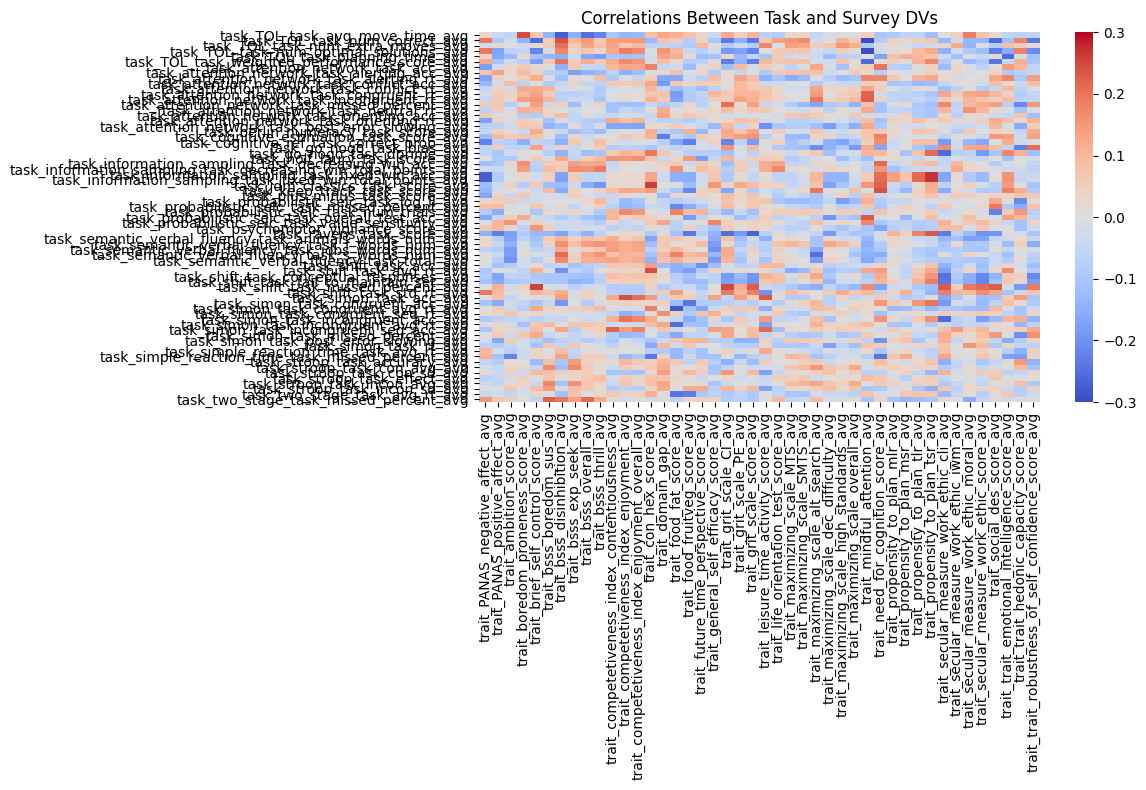

Average absolute correlation between task and survey DVs: 0.073, 95% CI [0.071, 0.075]


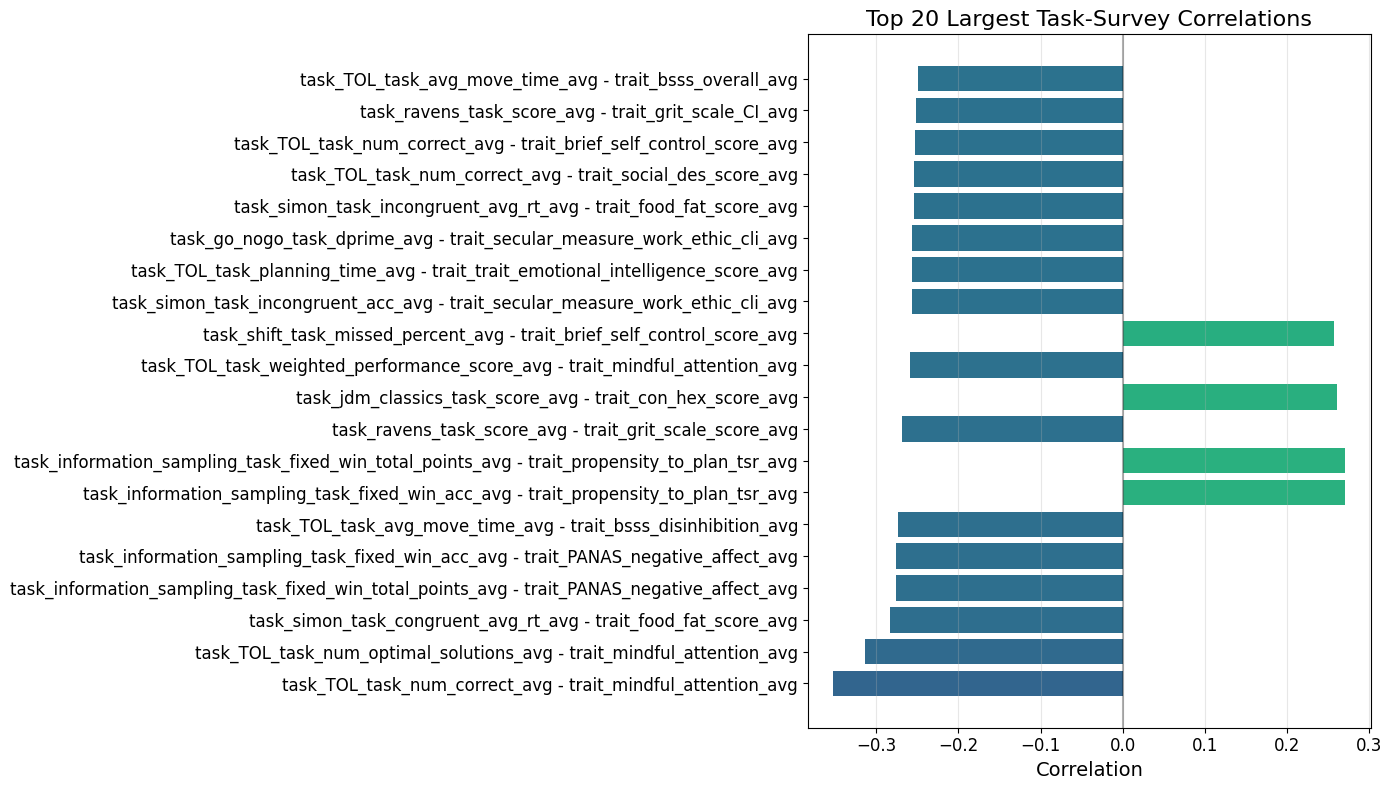

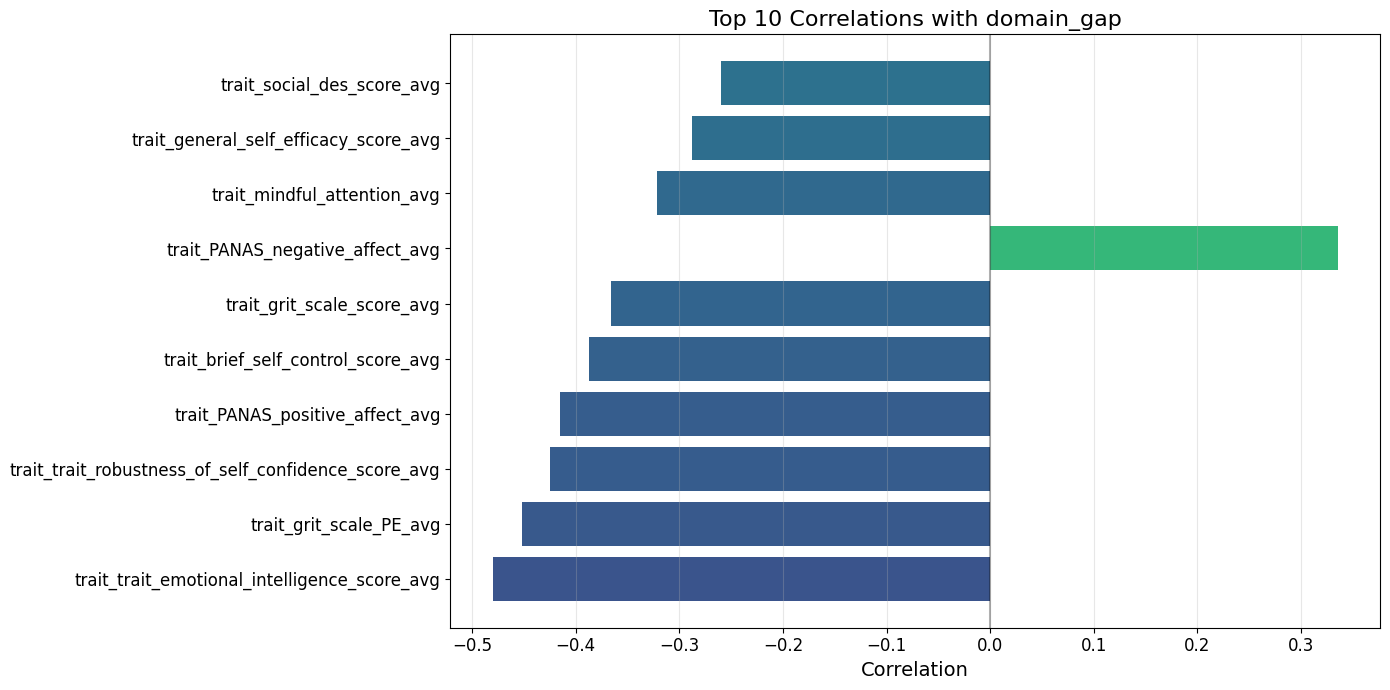

In [347]:
# Plot correlations between task and survey DVs
corr_matrix = plot_task_survey_correlation(task_df, survey_df)

## 3. Graph-Based Visualization of DV Relationships

In [348]:
def create_dv_graph(corr_matrix, threshold=0.3):
    """Create a graph representation of the relationships between DVs"""
    # Convert correlation matrix to partial correlations
    # In a real implementation, we would use the graphical lasso here
    # For simplicity, we'll use the correlation matrix thresholded
    adj_matrix = np.abs(corr_matrix.values) > threshold
    
    # Set diagonal to False to avoid self-loops
    np.fill_diagonal(adj_matrix, False)
    
    # Create graph
    G = nx.from_numpy_array(adj_matrix)
    
    # Add node attributes
    # Adjust for PID column in task_df
    n_task = len(task_df.columns) - 1  # Subtract 1 for PID column
    n_survey = len(survey_df.columns) - 1  # Subtract 1 for PID column
    
    # Get actual column names excluding PID
    task_node_names = [col for col in task_df.columns if col != 'PID']
    survey_node_names = [col for col in survey_df.columns if col != 'PID']
    
    # All node names combined for correlation lookup
    all_node_names = task_node_names + survey_node_names
    
    for i in range(len(G.nodes())):
        if i < n_task:
            G.nodes[i]['type'] = 'task'
            G.nodes[i]['name'] = task_node_names[i]
        else:
            G.nodes[i]['type'] = 'survey'
            G.nodes[i]['name'] = survey_node_names[i - n_task]
    
    # Get positions for nodes using spring layout
    pos = nx.spring_layout(G, k=0.2, iterations=50)
    
    # Create lists for plotly
    pos_edge_x = []
    pos_edge_y = []
    neg_edge_x = []
    neg_edge_y = []
    edge_widths = []
    pos_widths = []
    neg_widths = []
    
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        
        # Get correlation value for this edge
        name1 = G.nodes[edge[0]]['name']
        name2 = G.nodes[edge[1]]['name']
        idx1 = all_node_names.index(name1)
        idx2 = all_node_names.index(name2)
        corr_val = corr_matrix.iloc[idx1, idx2]
        
        # Set edge width based on correlation strength (scaled from 0.5 to 3)
        edge_width = 0.5 + 2.5 * (abs(corr_val) - threshold) / (1 - threshold)
        
        # Separate positive and negative correlations
        if corr_val > 0:
            pos_edge_x.extend([x0, x1, None])
            pos_edge_y.extend([y0, y1, None])
            pos_widths.append(edge_width)
        else:
            neg_edge_x.extend([x0, x1, None])
            neg_edge_y.extend([y0, y1, None])
            neg_widths.append(edge_width)
    
    # Create edge traces for positive and negative correlations
    pos_edge_trace = go.Scatter(
        x=pos_edge_x, y=pos_edge_y,
        line=dict(width=0, color='green'),  # Width set in customdata
        customdata=pos_widths,
        hoverinfo='none',
        mode='lines'
    )
    
    neg_edge_trace = go.Scatter(
        x=neg_edge_x, y=neg_edge_y,
        line=dict(width=0, color='red'),  # Width set in customdata
        customdata=neg_widths,
        hoverinfo='none',
        mode='lines'
    )
    
    # Apply varying widths to lines
    if pos_widths:
        pos_edge_trace.line.width = np.mean(pos_widths)
    if neg_widths:
        neg_edge_trace.line.width = np.mean(neg_widths)
    
    # Use the specified hex colors instead of viridis
    task_color = 'rgb(250, 218, 122)'  # #FADA7A in RGB
    survey_color = 'rgb(240, 160, 75)'  # #F0A04B in RGB
    
    # Create node traces for tasks and surveys
    task_nodes = [i for i in range(n_task)]
    survey_nodes = [i for i in range(n_task, n_task + n_survey)]
    
    # Create task node trace with enhanced hover info
    task_node_x = []
    task_node_y = []
    task_node_text = []
    for node in task_nodes:
        x, y = pos[node]
        task_node_x.append(x)
        task_node_y.append(y)
        
        # Get node name
        node_name = G.nodes[node]['name']
        
        # Find correlations for this node
        node_corrs = []
        for j, other_name in enumerate(all_node_names):
            if j != node:  # Skip self
                corr_val = corr_matrix.iloc[node, j]
                if abs(corr_val) > threshold:
                    node_corrs.append((other_name, corr_val))
        
        # Sort by absolute correlation strength
        node_corrs.sort(key=lambda x: abs(x[1]), reverse=True)
        
        # Create hover text
        hover_text = f"<b>{node_name}</b><br><br>Correlations:<br>"
        for other_name, corr_val in node_corrs:
            hover_text += f"{other_name}: {corr_val:.3f}<br>"
        
        task_node_text.append(hover_text)
    
    task_node_trace = go.Scatter(
        x=task_node_x, y=task_node_y,
        mode='markers',
        hoverinfo='text',
        text=task_node_text,
        hovertemplate='%{text}',
        marker=dict(
            color=task_color,
            size=10,
            line_width=1))
    
    # Create survey node trace with enhanced hover info
    survey_node_x = []
    survey_node_y = []
    survey_node_text = []
    for node in survey_nodes:
        x, y = pos[node]
        survey_node_x.append(x)
        survey_node_y.append(y)
        
        # Get node name
        node_name = G.nodes[node]['name']
        
        # Find correlations for this node
        node_corrs = []
        for j, other_name in enumerate(all_node_names):
            if j != node:  # Skip self
                corr_val = corr_matrix.iloc[node, j]
                if abs(corr_val) > threshold:
                    node_corrs.append((other_name, corr_val))
        
        # Sort by absolute correlation strength
        node_corrs.sort(key=lambda x: abs(x[1]), reverse=True)
        
        # Create hover text
        hover_text = f"<b>{node_name}</b><br><br>Correlations:<br>"
        for other_name, corr_val in node_corrs:
            hover_text += f"{other_name}: {corr_val:.3f}<br>"
        
        survey_node_text.append(hover_text)
    
    survey_node_trace = go.Scatter(
        x=survey_node_x, y=survey_node_y,
        mode='markers',
        hoverinfo='text',
        text=survey_node_text,
        hovertemplate='%{text}',
        marker=dict(
            color=survey_color,
            size=10,
            line_width=1))
    
    # Create the figure with separate edge traces
    fig = go.Figure(data=[pos_edge_trace, neg_edge_trace, task_node_trace, survey_node_trace],
                 layout=go.Layout(
                    title="Interactive Relationships between Task and Survey DVs",
                    titlefont_size=16,
                    showlegend=True,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    
    # Add legend
    fig.update_traces(name="Task DVs", selector=dict(type='scatter', mode='markers', marker_color=task_color))
    fig.update_traces(name="Survey DVs", selector=dict(type='scatter', mode='markers', marker_color=survey_color))
    fig.update_traces(name="Positive Correlations", selector=dict(type='scatter', mode='lines', line_color='green'))
    fig.update_traces(name="Negative Correlations", selector=dict(type='scatter', mode='lines', line_color='red'))
    
    # Show the figure
    fig.show()
    
    return G, fig

# Create and visualize the interactive DV relationship graph
G, fig = create_dv_graph(corr_matrix)

## Exploratory Factor Analysis

Finding optimal number of factors for task data...


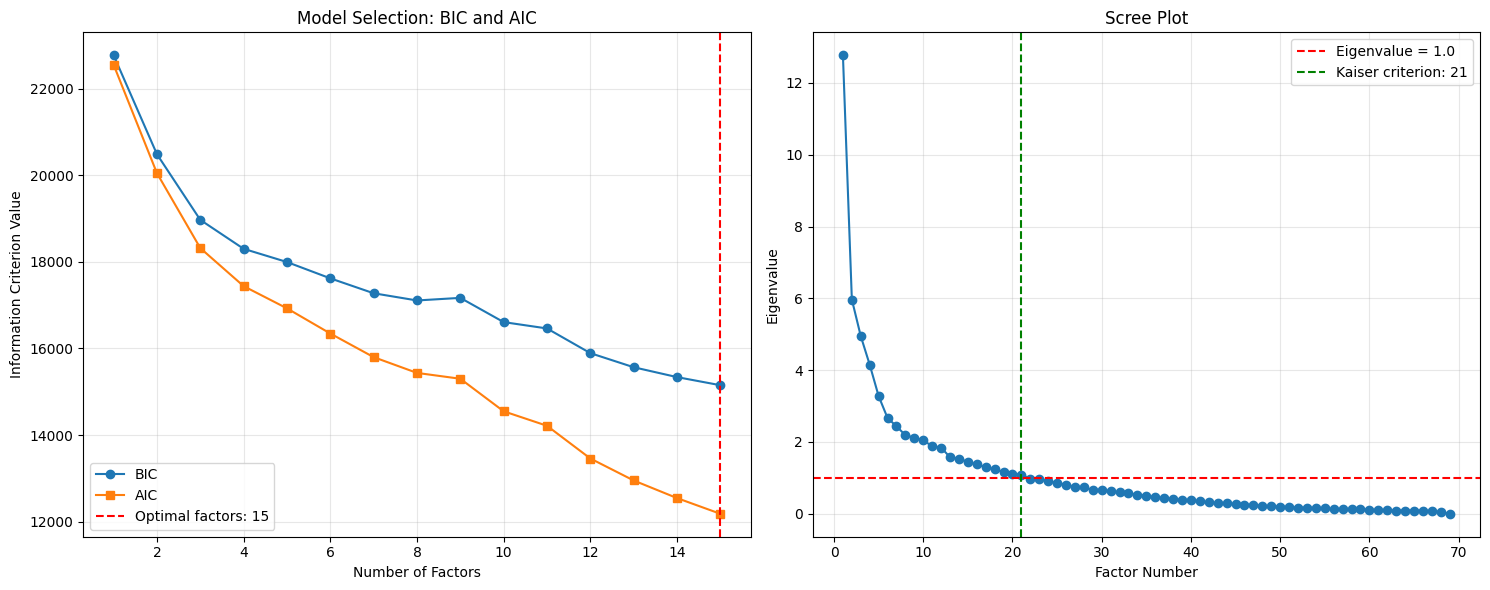

Finding optimal number of factors for survey data...


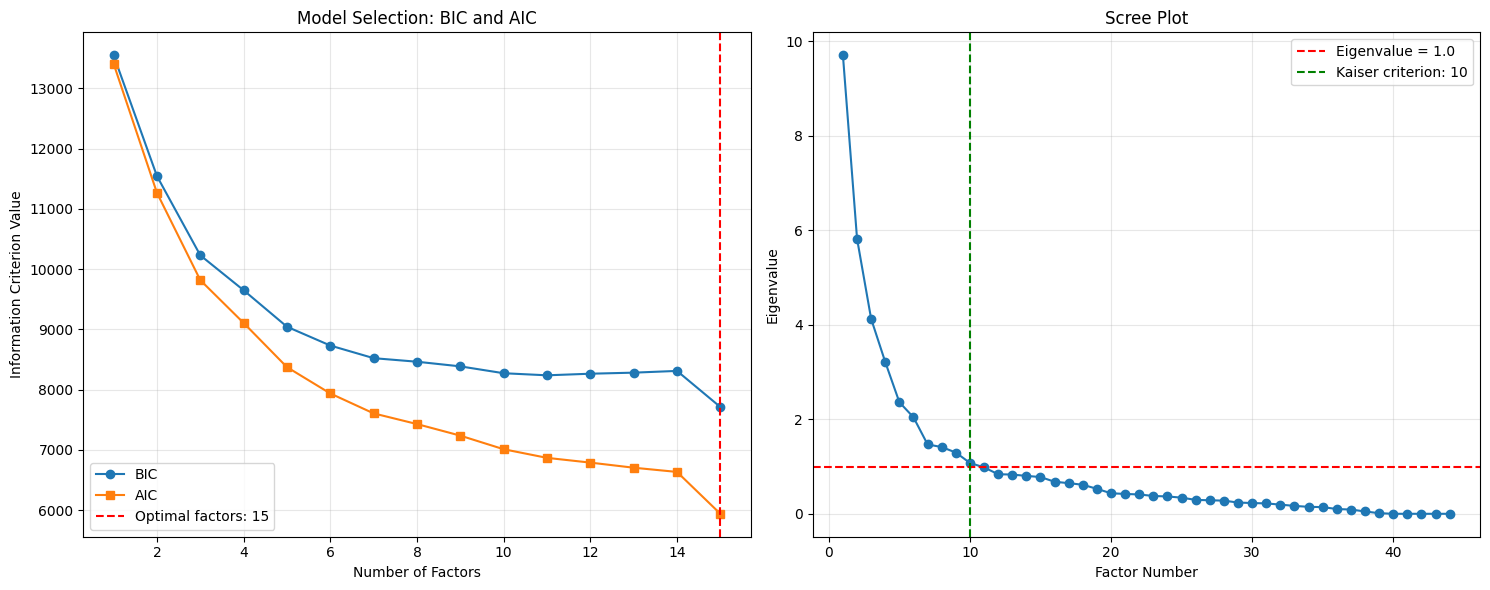

Finding optimal number of factors for outcome data...


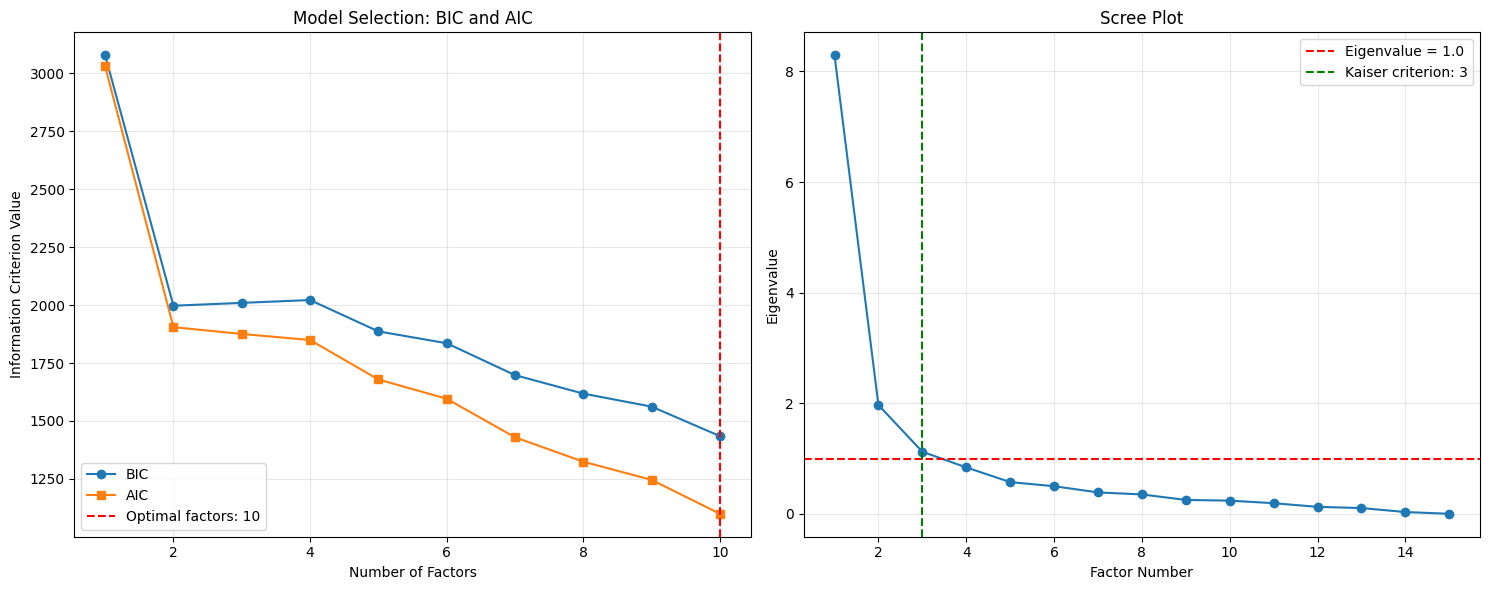

In [349]:
def find_optimal_factors(data, max_factors=15, method='ml'):
    """Find the optimal number of factors using BIC and scree plot"""
    # Make sure we're not using the PID column in the analysis
    if 'PID' in data.columns:
        data = data.drop(columns=['PID'])
    
    # Handle missing values for factor analysis (but keep original for correlation)
    data_for_fa = data.fillna(data.mean())
    
    # Check for columns with zero or near-zero variance
    variances = data_for_fa.var()
    low_var_cols = variances[variances < 1e-8].index.tolist()
    if low_var_cols:
        print(f"Warning: {len(low_var_cols)} columns with near-zero variance: {low_var_cols}")
        data_for_fa = data_for_fa.drop(columns=low_var_cols)
    
    n_samples, n_features = data_for_fa.shape
    bic_values = []
    aic_values = []
    
    # Calculate eigenvalues for scree plot using pairwise complete observations
    try:
        # Use pairwise complete observations for correlation calculation
        corr_matrix = data.corr(method='pearson')
        
        # Check for NaN or Inf values in correlation matrix
        if not np.isfinite(corr_matrix.values).all():
            print("Warning: Correlation matrix contains NaN or Inf values:")
            # Find pairs with NaN correlations
            nan_pairs = []
            for i in range(len(corr_matrix.columns)):
                for j in range(i+1, len(corr_matrix.columns)):
                    if not np.isfinite(corr_matrix.iloc[i, j]):
                        nan_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                                          corr_matrix.iloc[i, j]))
            
            # Print problematic pairs (up to 10)
            for i, (col1, col2, val) in enumerate(nan_pairs[:10]):
                print(f"  {col1} - {col2}: {val}")
            if len(nan_pairs) > 10:
                print(f"  ...and {len(nan_pairs) - 10} more problematic pairs")
            
            # Replace NaN/Inf with zeros for calculation purposes
            corr_matrix = corr_matrix.fillna(0).replace([np.inf, -np.inf], 0)
        
        # Ensure the matrix is positive semi-definite
        min_eig = np.min(np.linalg.eigvalsh(corr_matrix))
        if min_eig < 0:
            print(f"Warning: Correlation matrix is not positive definite. Smallest eigenvalue: {min_eig}")
            corr_matrix_fixed = corr_matrix.copy()
            # Add a small value to the diagonal to make it positive definite
            np.fill_diagonal(corr_matrix_fixed.values, np.diag(corr_matrix) - min_eig + 1e-6)
            eigenvalues = np.linalg.eigvalsh(corr_matrix_fixed)
        else:
            eigenvalues = np.linalg.eigvalsh(corr_matrix)
        
        # Sort eigenvalues in descending order
        eigenvalues = sorted(eigenvalues, reverse=True)
        
    except Exception as e:
        print(f"Error calculating eigenvalues: {e}")
        # Use a fallback method for eigenvalues
        print("Using fallback method for scree plot")
        # Just create some dummy eigenvalues for the scree plot
        eigenvalues = np.linspace(n_features, 0, n_features)[:-1]
    
    # Try different numbers of factors
    for n_factors in range(1, min(max_factors + 1, n_features)):
        try:
            # Fit factor model
            fa = FactorAnalyzer(n_factors=n_factors, rotation=None, method=method)
            fa.fit(data_for_fa)
            
            # Get factor variance explained
            variance_explained = fa.get_communalities().sum()
            
            # Simple estimation of log-likelihood
            log_like = -n_samples * (n_features - variance_explained)
            
            # Number of parameters: loadings + specificities - rotational indeterminacy
            n_params = n_factors * n_features - n_factors * (n_factors - 1) / 2
            
            # Calculate information criteria
            bic = -2 * log_like + n_params * np.log(n_samples)
            aic = -2 * log_like + 2 * n_params
            
            bic_values.append(bic)
            aic_values.append(aic)
            
        except Exception as e:
            print(f"Error fitting {n_factors} factors: {e}")
            # Add a large value to indicate failure
            bic_values.append(float('inf'))
            aic_values.append(float('inf'))
    
    # Find optimal number of factors
    if not all(np.isinf(bic_values)):
        optimal_n_factors = np.argmin(bic_values) + 1
    else:
        optimal_n_factors = 1  # Default if all failed
        
    # Calculate Kaiser criterion
    kaiser_factors = sum(1 for ev in eigenvalues if ev > 1.0)
    if kaiser_factors == 0:  # Safety check
        kaiser_factors = 1
    
    # Create figure with 2 subplots
    plt.figure(figsize=(15, 6))
    
    # Plot 1: BIC and AIC
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(bic_values) + 1), bic_values, 'o-', label='BIC')
    plt.plot(range(1, len(aic_values) + 1), aic_values, 's-', label='AIC')
    plt.axvline(x=optimal_n_factors, color='r', linestyle='--', 
                label=f'Optimal factors: {optimal_n_factors}')
    plt.xlabel('Number of Factors')
    plt.ylabel('Information Criterion Value')
    plt.title('Model Selection: BIC and AIC')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Scree plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-')
    plt.axhline(y=1.0, color='r', linestyle='--', label='Eigenvalue = 1.0')
    plt.axvline(x=kaiser_factors, color='g', linestyle='--', 
                label=f'Kaiser criterion: {kaiser_factors}')
    plt.xlabel('Factor Number')
    plt.ylabel('Eigenvalue')
    plt.title('Scree Plot')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return optimal_n_factors, kaiser_factors, bic_values, aic_values, eigenvalues

def perform_efa(data, n_factors, rotation='oblimin'):
    """Perform EFA and return the factor loadings and factor scores"""
    # Make sure we're not using the PID column in the analysis
    if 'PID' in data.columns:
        X = data.drop(columns=['PID'])
    else:
        X = data.copy()
    
    # Handle missing values
    X = X.fillna(X.mean())
    
    try:
        # Fit the factor model
        fa = FactorAnalyzer(n_factors=n_factors, rotation=rotation, method='ml')
        fa.fit(X)
        
        # Get loadings
        loadings = fa.loadings_
        
        # Calculate factor scores using a simplified approach
        # Standardize the data
        X_std = (X - X.mean()) / X.std()
        # Calculate factor scores using the loadings
        factor_scores = X_std.dot(loadings)
        
        # Compute communality (variance explained)
        communality = np.sum(loadings**2, axis=1)
        total_communality = np.mean(communality)
        
        # Print top loadings for interpretation
        column_names = X.columns.tolist()
        print(f"\nTop loadings for {n_factors} factors:")
        for i in range(n_factors):
            sorted_idx = np.argsort(-np.abs(loadings[:, i]))
            top_vars = [column_names[idx] for idx in sorted_idx[:5]]
            top_loadings = [loadings[idx, i] for idx in sorted_idx[:5]]
            print(f"Factor {i+1}:")
            for var, loading in zip(top_vars, top_loadings):
                print(f"  {var}: {loading:.3f}")
        
        return loadings, factor_scores.values, communality, total_communality
    
    except Exception as e:
        print(f"Error in EFA: {e}")
        # Return placeholder values
        return np.zeros((X.shape[1], n_factors)), np.zeros((X.shape[0], n_factors)), np.zeros(X.shape[1]), 0.0

# Determine optimal number of factors using multiple criteria
print("Finding optimal number of factors for task data...")
task_bic_optimal, task_kaiser_optimal, task_bic, task_aic, task_eigenvalues = find_optimal_factors(task_df, max_factors=15)

print("Finding optimal number of factors for survey data...")
survey_bic_optimal, survey_kaiser_optimal, survey_bic, survey_aic, survey_eigenvalues = find_optimal_factors(survey_df, max_factors=15)

print("Finding optimal number of factors for outcome data...")
outcome_bic_optimal, outcome_kaiser_optimal, outcome_bic, outcome_aic, outcome_eigenvalues = find_optimal_factors(outcome_df, max_factors=10)

In [350]:
# Choose factor number
task_n_factors = 6
survey_n_factors = 7
outcome_n_factors = 2

# Use the optimal number of factors in EFA
print(f"\nRunning EFA with factors based on scree plot selection: Task={task_n_factors}, Survey={survey_n_factors}, Outcome={outcome_n_factors}")
task_loadings, task_factor_scores, task_communality, task_total_communality = perform_efa(task_df, task_n_factors)
survey_loadings, survey_factor_scores, survey_communality, survey_total_communality = perform_efa(survey_df, survey_n_factors)
outcome_loadings, outcome_factor_scores, outcome_communality, outcome_total_communality = perform_efa(outcome_df, outcome_n_factors)

# Print variance explained
print(f"\nTask EFA total variance explained: {task_total_communality:.3f}")
print(f"Survey EFA total variance explained: {survey_total_communality:.3f}")
print(f"Outcome EFA total variance explained: {outcome_total_communality:.3f}")


Running EFA with factors based on scree plot selection: Task=6, Survey=7, Outcome=2

Top loadings for 6 factors:
Factor 1:
  battery_task_semantic_verbal_fluency_task_total_avg: 0.998
  battery_task_semantic_verbal_fluency_task_jobs_words_num_avg: 0.934
  battery_task_semantic_verbal_fluency_task_f_words_num_avg: 0.886
  battery_task_semantic_verbal_fluency_task_animals_words_num_avg: 0.863
  battery_task_semantic_verbal_fluency_task_s_words_num_avg: 0.834
Factor 2:
  battery_task_stroop_task_incon_avg_avg: 0.968
  battery_task_stroop_task_con_avg_avg: 0.841
  battery_task_stroop_task_accuracy_avg: 0.746
  battery_task_stroop_task_effect_avg: 0.699
  battery_task_stroop_task_incon_sd_avg: 0.434
Factor 3:
  battery_task_attention_network_task_incongruent_rt_avg: 0.941
  battery_task_attention_network_task_congruent_rt_avg: 0.915
  battery_task_attention_network_task_neutral_rt_avg: 0.731
  battery_task_attention_network_task_conflict_rt_avg: 0.488
  battery_task_simon_task_incongruent_

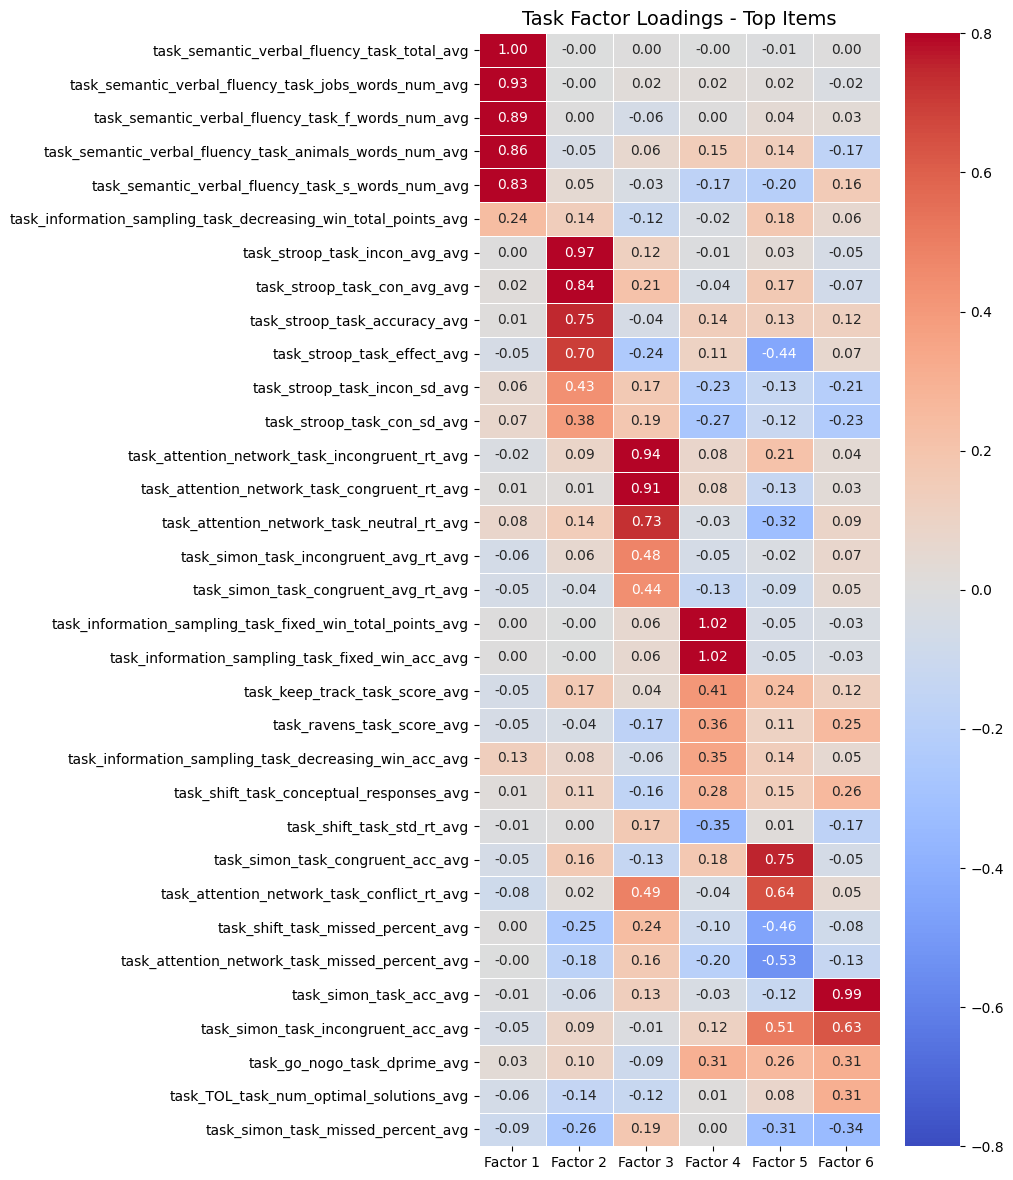

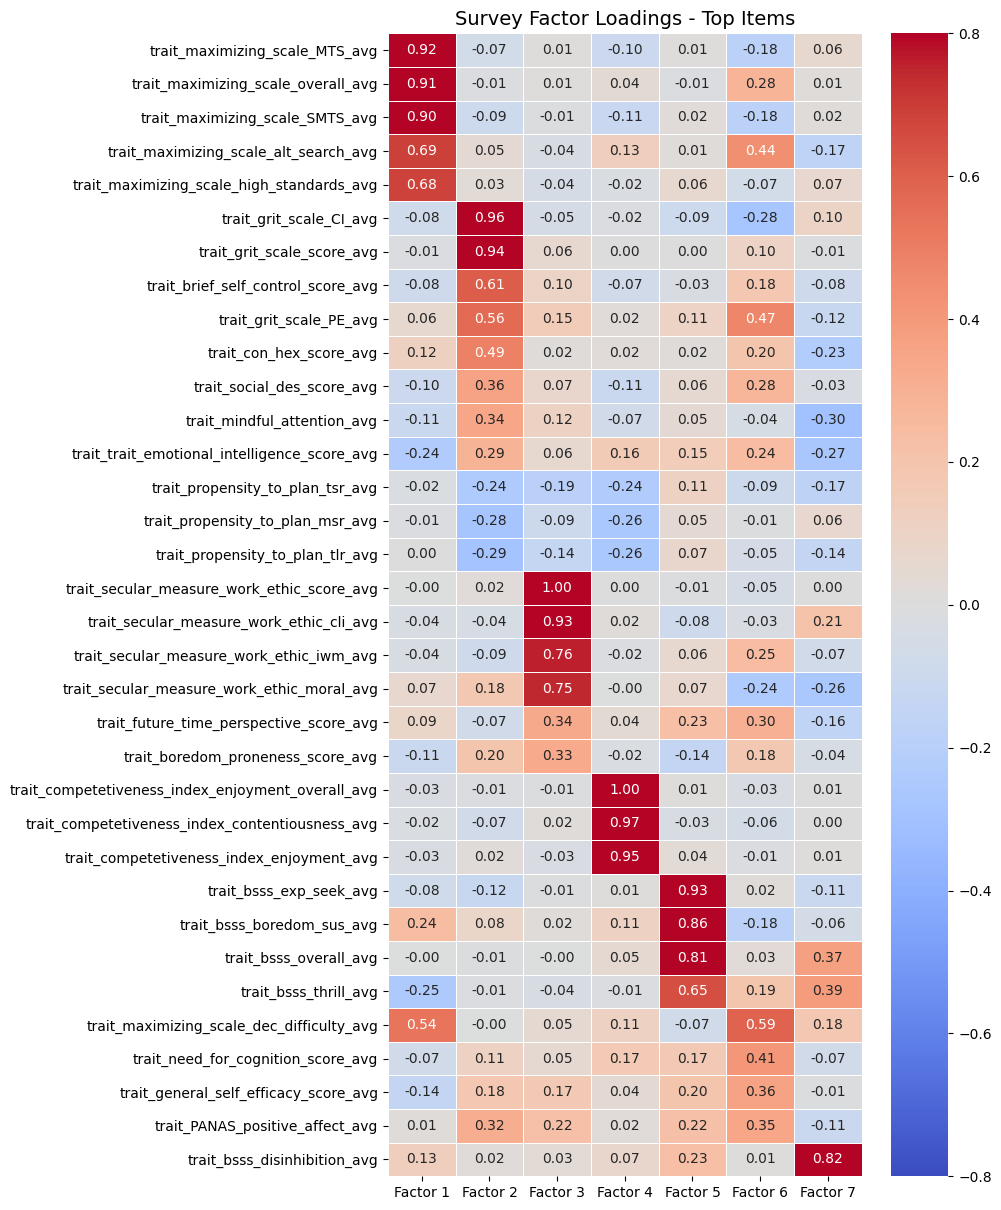

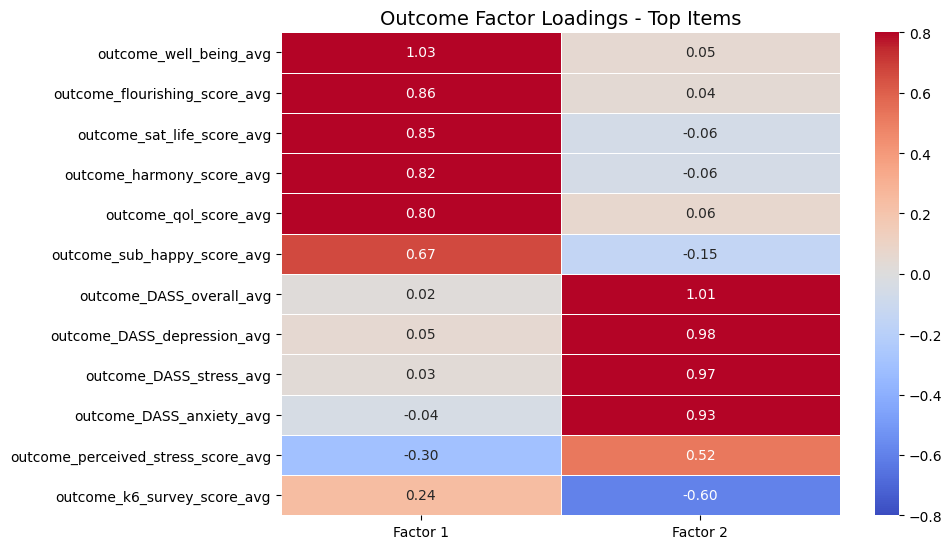

In [364]:
# Visualize factor loadings with a heatmap

def plot_factor_loadings(loadings, columns, title, n_top_items=10):
    """
    Create a heatmap of factor loadings, highlighting the top items for each factor.
    
    Parameters:
    -----------
    loadings : numpy.ndarray
        Factor loadings matrix (variables × factors)
    columns : list
        Original variable names
    title : str
        Plot title
    n_top_items : int
        Number of top items to display per factor
    """
    # Create DataFrame for easier handling
    loadings_df = pd.DataFrame(loadings, index=columns)
    
    # Rename columns to Factor 1, Factor 2, etc.
    loadings_df.columns = [f'Factor {i+1}' for i in range(loadings_df.shape[1])]
    
    # For each factor, get the variables with the highest absolute loadings
    top_loadings = {}
    all_top_vars = set()
    
    for col in loadings_df.columns:
        # Sort by absolute loading values
        top_vars = loadings_df[col].abs().sort_values(ascending=False).head(n_top_items).index
        top_loadings[col] = top_vars
        all_top_vars.update(top_vars)
    
    # Create a new DataFrame with only the top variables
    top_df = loadings_df.loc[list(all_top_vars)]
    
    # Clean variable names by removing prefixes for display
    clean_index = [name.replace('battery_', '') for name in top_df.index]
    top_df.index = clean_index
    
    # Sort rows to group similar variables
    top_df_sorted = top_df.copy()
    
    # Find the factor with the highest loading for each variable
    max_factor = top_df.abs().idxmax(axis=1)
    
    # Sort by the factor with highest loading, then by loading value within each factor
    top_df_sorted['max_factor'] = max_factor
    # Replace the deprecated lookup method with modern approach
    top_df_sorted['max_loading'] = [top_df_sorted.loc[idx, col] for idx, col in zip(top_df_sorted.index, max_factor)]
    top_df_sorted = top_df_sorted.sort_values(['max_factor', 'max_loading'], ascending=[True, False])
    
    # Remove helper columns
    top_df_sorted = top_df_sorted.drop(['max_factor', 'max_loading'], axis=1)
    
    # Create heatmap with custom diverging colormap
    plt.figure(figsize=(10, len(all_top_vars) * 0.3 + 2))
    ax = sns.heatmap(top_df_sorted, 
                    cmap="coolwarm", 
                    center=0, 
                    vmin=-0.8, vmax=0.8,
                    annot=True, 
                    fmt=".2f", 
                    linewidths=0.5)
    
    plt.title(f"{title} Factor Loadings - Top Items", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Return for further analysis if needed
    return top_df_sorted

# Visualize task factor loadings
task_top_loadings = plot_factor_loadings(task_loadings, task_columns, "Task", n_top_items=6)

# Visualize survey factor loadings 
survey_top_loadings = plot_factor_loadings(survey_loadings, survey_columns, "Survey", n_top_items=6)

# Visualize outcome factor loadings
outcome_top_loadings = plot_factor_loadings(outcome_loadings, outcome_columns, "Outcome", n_top_items=6)

## Hierarchical Clustering and Visualization

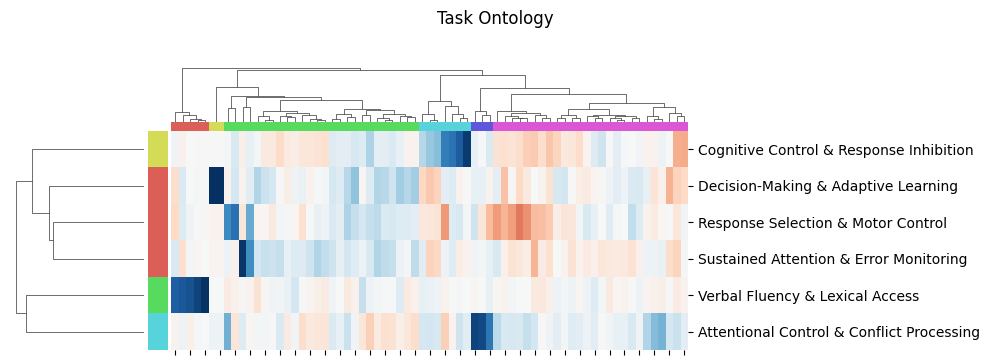

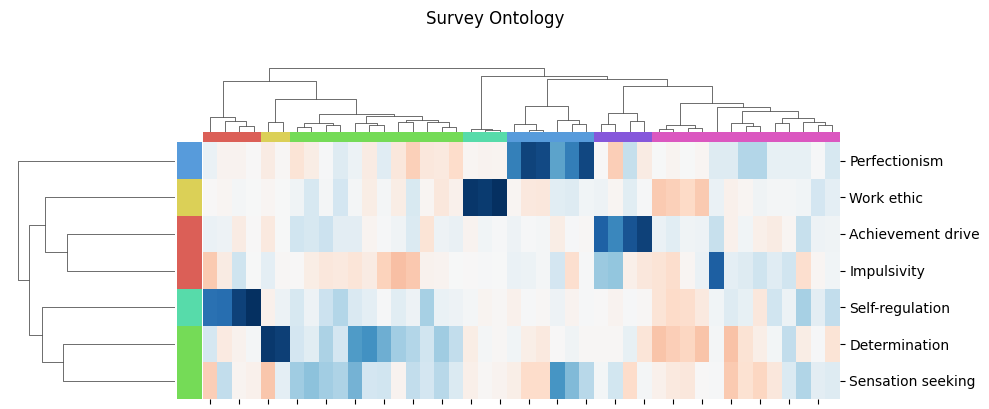

In [377]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster

def plot_factor_loadings_heatmap(
    loadings, 
    row_labels, 
    col_labels, 
    n_clusters=5, 
    title="Clustered Heatmap"
):
    """
    Create a hierarchical-clustering heatmap with colored clusters.

    Parameters
    ----------
    loadings : 2D array-like (rows x columns)
        Factor loadings or any 2D numeric data to be plotted.
    row_labels : list of str
        Labels for each row (e.g., variable names).
    col_labels : list of str
        Labels for each column (e.g., factor names).
    n_clusters : int, optional
        Number of clusters to form for coloring rows/columns.
    title : str, optional
        Title of the plot.

    Returns
    -------
    sns.matrix.ClusterGrid
        The Seaborn ClusterGrid object for further customization.
    """
    # Convert loadings to a DataFrame - TRANSPOSE the data here
    df = pd.DataFrame(loadings.T, index=col_labels, columns=row_labels)

    # 1) Linkage for rows (now these are the original columns)
    row_dist = pdist(df.values, metric='euclidean')
    row_linkage = linkage(row_dist, method='ward')

    # 2) Linkage for columns (now these are the original rows)
    col_dist = pdist(df.values.T, metric='euclidean')
    col_linkage = linkage(col_dist, method='ward')

    # 3) Cluster assignments for rows and columns
    row_clusters = fcluster(row_linkage, t=n_clusters, criterion='maxclust')
    col_clusters = fcluster(col_linkage, t=n_clusters, criterion='maxclust')

    # 4) Create a color palette for clusters
    palette = sns.color_palette("hls", n_clusters)

    # Map each cluster assignment to a color
    row_colors = [palette[c - 1] for c in row_clusters]
    col_colors = [palette[c - 1] for c in col_clusters]

    # 5) Create the cluster heatmap
    g = sns.clustermap(
        df,
        row_linkage=row_linkage,
        col_linkage=col_linkage,
        row_colors=row_colors,
        col_colors=col_colors,
        cmap="RdBu",
        center=0,
        figsize=(10, 8),
        cbar_kws={'label': None}
    )
    
    # Remove the colorbar completely
    g.cax.set_visible(False)

    # 6) Add the plot title
    g.fig.suptitle(title, y=1.05)

    # 7) Adjust label rotation, etc.
    g.ax_heatmap.set_xticklabels([])  # Remove x-tick labels
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)

    plt.show()
    return g


# -------------- USAGE EXAMPLE --------------
if __name__ == "__main__":
    # Generate random data as an example
    np.random.seed(42)
    example_loadings = np.random.randn(6, 6)  # 10 rows, 8 columns

    task_col_labels = [
        "Verbal Fluency & Lexical Access", "Cognitive Control & Response Inhibition",
        "Attentional Control & Conflict Processing",
        "Decision-Making & Adaptive Learning", 
        "Response Selection & Motor Control", "Sustained Attention & Error Monitoring",
    ]

    # Assuming you want to use the actual task names from task_columns:
    plot_factor_loadings_heatmap(
        loadings=task_loadings,
        row_labels=task_columns,  # These should be all 69 task names
        col_labels= task_col_labels, # [f"Factor {i+1}" for i in range(6)],  # Generate factor labels
        n_clusters=6, 
        title="Task Ontology"
    )
    
    survey_col_labels = ['Perfectionism', 'Determination', 'Self-regulation',
                         'Work ethic', 'Achievement drive', 'Sensation seeking', 'Impulsivity'
                         ]
    
        # Assuming you want to use the actual task names from task_columns:
    plot_factor_loadings_heatmap(
        loadings=survey_loadings,
        row_labels=survey_columns,  
        col_labels= survey_col_labels, # [f"Factor {i+1}" for i in range(6)],  # Generate factor labels
        n_clusters=7, 
        title="Survey Ontology"
    )

## Factor Score Reliability and Retest Analysis

In [ ]:
def simulate_retest_data(dvs, factor_scores, loadings, noise_level=0.5):
    """Simulate retest data by adding noise to original data"""
    # Add some noise to the factor scores
    retest_factor_scores = factor_scores + np.random.normal(0, noise_level, factor_scores.shape)
    
    # Regenerate DVs from the new factor scores
    retest_dvs = np.dot(retest_factor_scores, loadings.T)
    retest_dvs += np.random.normal(0, noise_level, retest_dvs.shape)
    
    return retest_dvs, retest_factor_scores

# Simulate retest data for 150 participants
retest_size = 150
task_retest_dvs, task_retest_true_factors = simulate_retest_data(
    task_dvs[:retest_size], task_factor_scores[:retest_size], task_loadings)
survey_retest_dvs, survey_retest_true_factors = simulate_retest_data(
    survey_dvs[:retest_size], survey_factor_scores[:retest_size], survey_loadings)

# Calculate retest factor scores using original loadings
task_retest_factor_scores = np.dot(StandardScaler().fit_transform(task_retest_dvs), 
                                 np.linalg.inv(np.corrcoef(task_dvs, rowvar=False)).dot(task_loadings))
survey_retest_factor_scores = np.dot(StandardScaler().fit_transform(survey_retest_dvs), 
                                   np.linalg.inv(np.corrcoef(survey_dvs, rowvar=False)).dot(survey_loadings))

def plot_factor_stability(factor_scores1, factor_scores2, title):
    """Plot factor score stability and correlations"""
    n_factors = factor_scores1.shape[1]
    
    # Calculate correlations
    corr_matrix = np.zeros((n_factors, n_factors))
    for i in range(n_factors):
        for j in range(n_factors):
            corr_matrix[i, j] = np.corrcoef(factor_scores1[:, i], factor_scores2[:, j])[0, 1]
    
    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    
    # Lower triangle: test-retest correlations
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
               mask=mask, square=True, fmt='.2f')
    
    # Upper triangle: factor correlations at time 1
    time1_corr = np.corrcoef(factor_scores1, rowvar=False)
    sns.heatmap(time1_corr, annot=True, cmap='PuOr', vmin=-1, vmax=1, 
               mask=~mask, square=True, fmt='.2f')
    
    plt.title(f'{title} Factor Stability')
    factor_names = [f'F{i+1}' for i in range(n_factors)]
    plt.xticks(np.arange(n_factors) + 0.5, factor_names)
    plt.yticks(np.arange(n_factors) + 0.5, factor_names)
    
    # Show diagonal reliability
    diag_reliability = np.diag(corr_matrix)
    print(f"{title} factor score reliability:")
    for i, rel in enumerate(diag_reliability):
        print(f"  Factor {i+1}: {rel:.3f}")
    print(f"  Mean: {np.mean(diag_reliability):.3f}")
    
    plt.tight_layout()
    plt.show()
    
    # Create PCA visualization of stability
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=2)
    combined_factors = np.vstack([factor_scores1, factor_scores2])
    pca_result = pca.fit_transform(combined_factors)
    
    plt.figure(figsize=(10, 8))
    
    # Plot lines connecting test-retest pairs
    for i in range(len(factor_scores1)):
        plt.plot([pca_result[i, 0], pca_result[i+len(factor_scores1), 0]], 
                 [pca_result[i, 1], pca_result[i+len(factor_scores1), 1]], 
                 'k-', alpha=0.2)
    
    # Plot points
    plt.scatter(pca_result[:len(factor_scores1), 0], pca_result[:len(factor_scores1), 1], 
               c='blue', alpha=0.7, label='Time 1')
    plt.scatter(pca_result[len(factor_scores1):, 0], pca_result[len(factor_scores1):, 1], 
               c='red', alpha=0.7, label='Time 2')
    
    plt.title(f'{title} Factor Scores: 2D Projection')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot factor stability
plot_factor_stability(task_factor_scores[:retest_size], task_retest_factor_scores, "Task")
plot_factor_stability(survey_factor_scores[:retest_size], survey_retest_factor_scores, "Survey")

## Predicting Real-World Outcomes


Summary of prediction performance (R²):
----------------------------------------
Outcome              Task CV    Survey CV 
------------------------------------------------------------
Well-being           0.0000     0.4689
BMI                  0.0000     0.0000
Academic grades      0.0341     0.0000

Task Factor Key:
----------------
VF: Verbal Fluency & Lexical Access
CC: Cognitive Control & Response Inhibition
AC: Attentional Control & Conflict Processing
DM: Decision-Making & Adaptive Learning
RS: Response Selection & Motor Control
SA: Sustained Attention & Error Monitoring

Survey Factor Key:
------------------
PF: Perfectionism
DT: Determination
SR: Self-regulation
WE: Work ethic
AD: Achievement drive
SS: Sensation seeking
IM: Impulsivity


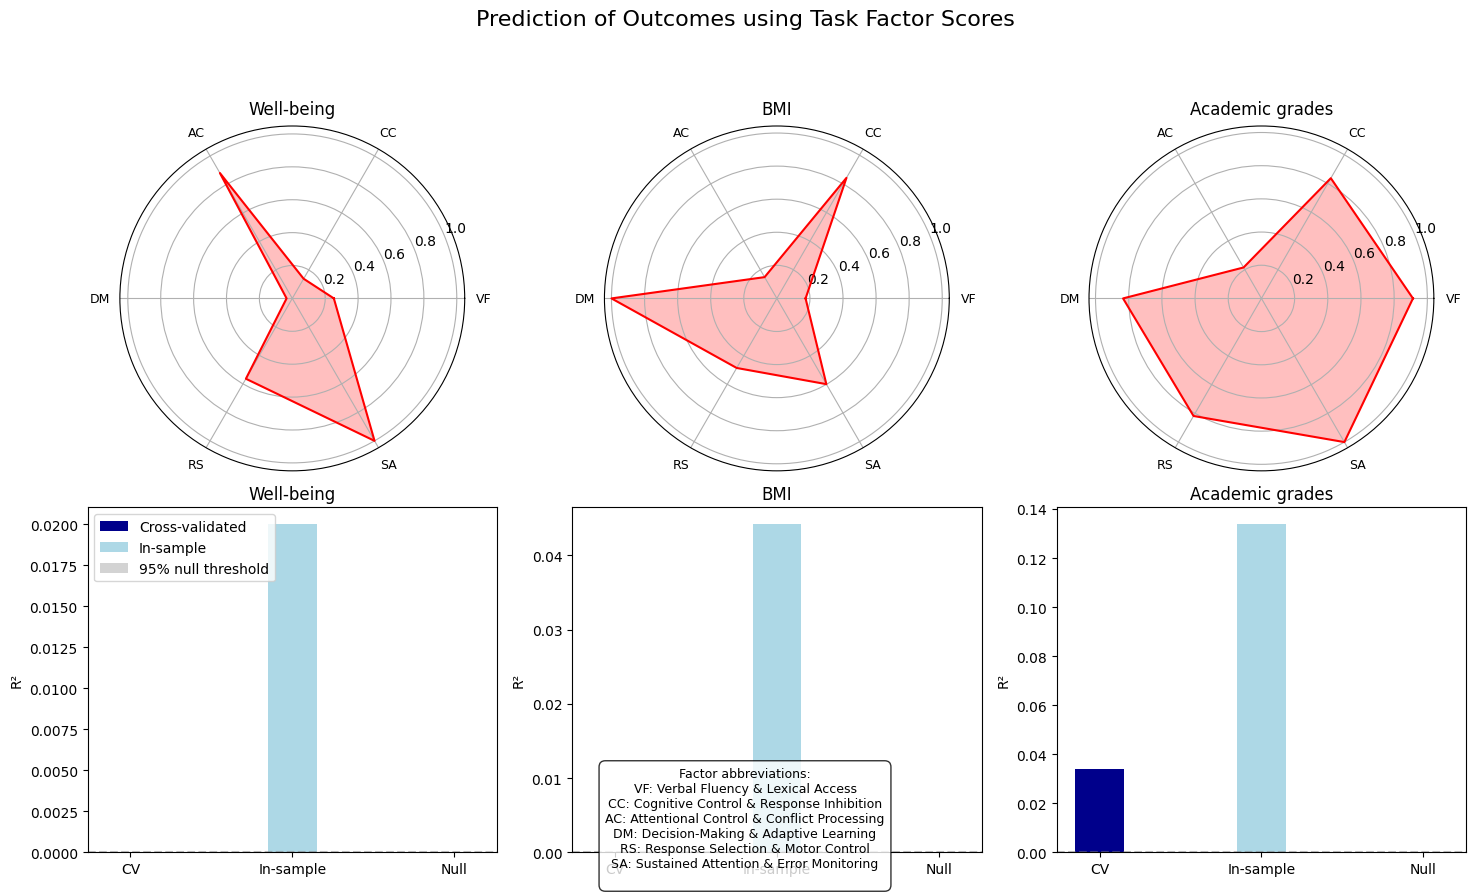

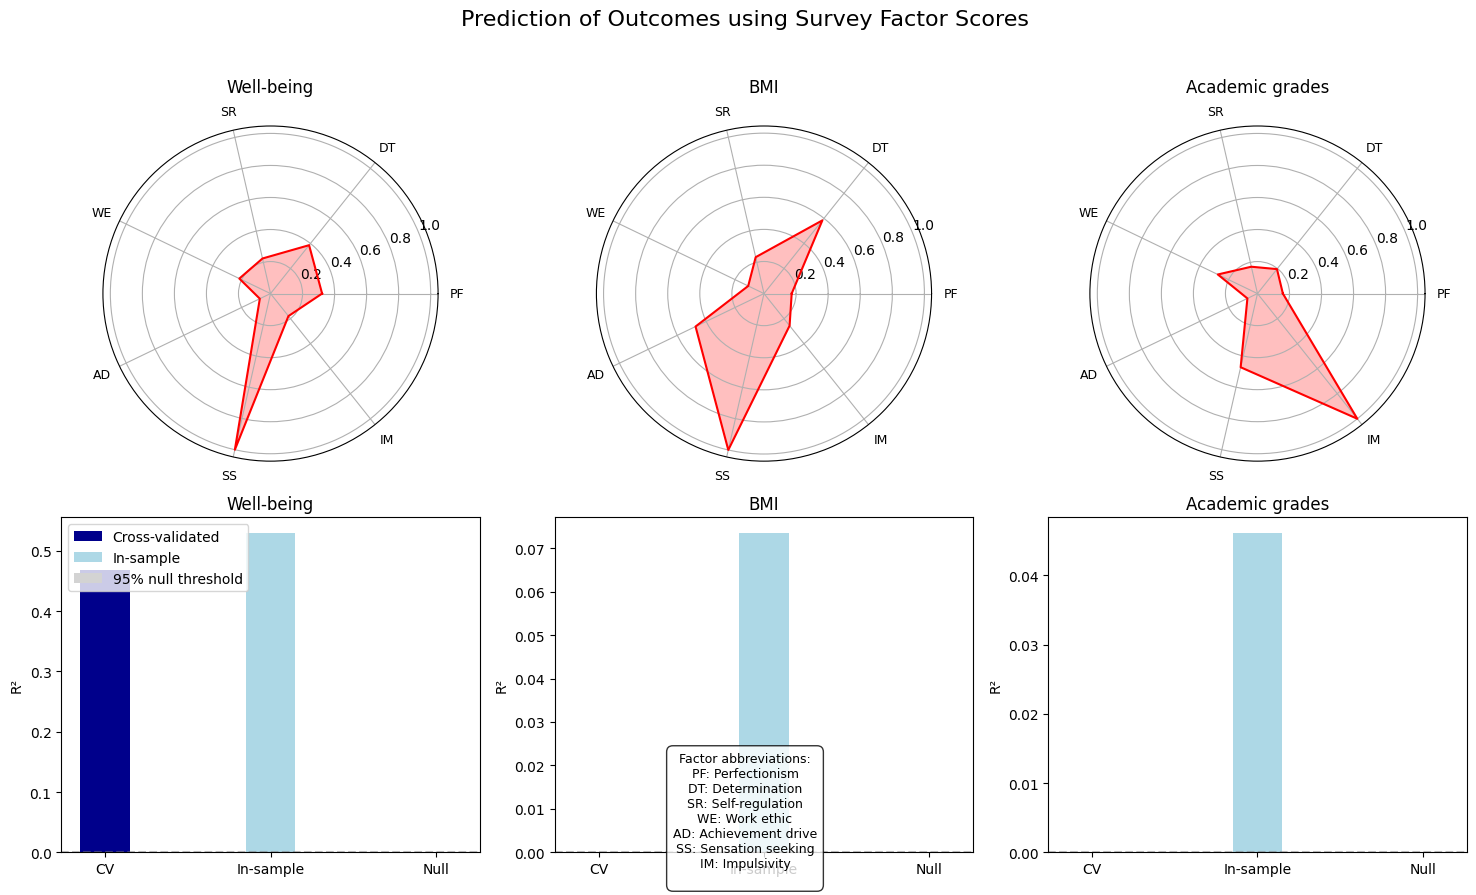

In [388]:
# First, let's extract the specific outcome variables we want to analyze
wellbeing_idx = [i for i, col in enumerate(outcome_columns) 
                if 'well_being_avg' in col][0]
bmi_idx = [i for i, col in enumerate(outcome_columns) 
          if 'bmi_avg' in col][0]
grades_idx = [i for i, col in enumerate(outcome_columns) 
             if 'grades_avg_avg' in col][0]

# Define abbreviated labels for task and survey factors
task_abbr_labels = ['VF', 'CC', 'AC', 'DM', 'RS', 'SA']  # Abbreviated labels
task_full_labels = [  # Full descriptive labels
    "Verbal Fluency & Lexical Access", 
    "Cognitive Control & Response Inhibition",
    "Attentional Control & Conflict Processing",
    "Decision-Making & Adaptive Learning", 
    "Response Selection & Motor Control", 
    "Sustained Attention & Error Monitoring"
]

survey_abbr_labels = ['PF', 'DT', 'SR', 'WE', 'AD', 'SS', 'IM']  # Abbreviated labels
survey_full_labels = [  # Full descriptive labels
    'Perfectionism', 
    'Determination', 
    'Self-regulation',
    'Work ethic', 
    'Achievement drive', 
    'Sensation seeking', 
    'Impulsivity'
]

# Create a function to predict specific outcomes and visualize results with absolute correlations
def predict_specific_outcomes(predictor_scores, predictor_type, abbr_labels, full_labels, n_splits=10, alpha=1.0):
    """Predict specific outcomes and visualize results with absolute correlation fingerprints"""
    
    # Get the raw outcome data directly from df_battery
    outcome_columns = ['battery_outcome_well_being_avg', 'battery_outcome_bmi_avg', 'battery_outcome_grades_avg_avg']
    outcomes_data = df_battery[outcome_columns].values
    
    # Target names for display
    target_names = ['Well-being', 'BMI', 'Academic grades']
    
    # Setup figure with multiple subplots
    fig = plt.figure(figsize=(15, 9))
    
    # Create top row for ontological fingerprints
    axes_top = []
    for i in range(3):
        ax = fig.add_subplot(2, 3, i+1, projection='polar')
        axes_top.append(ax)
        
    # Create bottom row for bar charts
    axes_bottom = []
    for i in range(3):
        ax = fig.add_subplot(2, 3, i+4)
        axes_bottom.append(ax)
    
    # Initialize arrays for results
    cv_r2 = np.zeros(3)
    insample_r2 = np.zeros(3)
    beta_values = []
    
    # Create null distribution with shuffling
    n_shuffles = 100
    null_r2 = np.zeros((n_shuffles, 3))
    
    # Cross-validation setup
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Predict each target outcome
    for i, target_name in enumerate(target_names):
        # Get the specific outcome data
        target = outcomes_data[:, i]
        
        # Handle missing values
        valid_mask = ~np.isnan(target)
        if np.sum(valid_mask) < len(target):
            print(f"Warning: {target_name} has {len(target) - np.sum(valid_mask)} missing values")
            target = target[valid_mask]
            predictors_subset = predictor_scores[valid_mask]
        else:
            predictors_subset = predictor_scores
        
        # Cross-validated prediction
        model = Ridge(alpha=alpha)
        y_pred = cross_val_predict(model, predictors_subset, target, cv=kf)
        cv_r2[i] = max(0, r2_score(target, y_pred))  # Floor at 0
        
        # In-sample prediction
        model.fit(predictors_subset, target)
        y_pred_insample = model.predict(predictors_subset)
        insample_r2[i] = r2_score(target, y_pred_insample)
        
        # Store beta values
        beta_values.append(model.coef_)
        
        # Create null distribution
        for j in range(n_shuffles):
            target_shuffled = np.random.permutation(target)
            y_pred_shuffled = cross_val_predict(model, predictors_subset, target_shuffled, cv=kf)
            null_r2[j, i] = max(0, r2_score(target_shuffled, y_pred_shuffled))
        
        # Create bar chart
        ax = axes_bottom[i]
        x = np.array([0, 1, 2])
        width = 0.3
        
        ax.bar(x[0], cv_r2[i], width, label='Cross-validated', color='darkblue')
        ax.bar(x[1], insample_r2[i], width, label='In-sample', color='lightblue')
        
        # Add 95% null threshold
        null_95 = np.percentile(null_r2[:, i], 95)
        ax.bar(x[2], null_95, width, label='95% null threshold', color='lightgray')
        ax.axhline(y=null_95, color='gray', linestyle='--', alpha=0.5)
        
        ax.set_ylabel('R²')
        ax.set_title(f'{target_name}')
        ax.set_xticks(x)
        ax.set_xticklabels(['CV', 'In-sample', 'Null'])
        if i == 0:
            ax.legend(loc='upper left')
        
        # Create ontological fingerprint (polar plot)
        ax = axes_top[i]
        
        # Get beta values for this prediction
        beta = beta_values[i]
        
        # Take absolute values and standardize
        abs_beta = np.abs(beta)
        std_abs_beta = abs_beta / np.max(abs_beta) if np.max(abs_beta) > 0 else abs_beta
        
        # Create angles and plot
        angles = np.linspace(0, 2*np.pi, len(std_abs_beta), endpoint=False)
        
        # Close the plot
        values = np.concatenate((std_abs_beta, [std_abs_beta[0]]))
        angles_plot = np.concatenate((angles, [angles[0]]))
        
        # Plot the polar plot
        ax.plot(angles_plot, values, 'r-')
        ax.fill(angles_plot, values, 'r', alpha=0.25)
        
        # Set the labels using abbreviations
        ax.set_xticks(angles)
        ax.set_xticklabels(abbr_labels, fontsize=9)
        
        # Set title
        ax.set_title(f'{target_name}', va='bottom')
    
    plt.suptitle(f'Prediction of Outcomes using {predictor_type} Factor Scores', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # Add abbreviation legend
    legend_text = "Factor abbreviations:\n"
    for abbr, full in zip(abbr_labels, full_labels):
        legend_text += f"{abbr}: {full}\n"
    
    # Add text box with abbreviation legend
    plt.figtext(0.5, 0.01, legend_text, ha='center', fontsize=9, 
               bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    return cv_r2, insample_r2, beta_values

# Run prediction and visualization for task factors
task_outcome_r2, task_outcome_insample_r2, task_outcome_betas = predict_specific_outcomes(
    task_factor_scores, "Task", task_abbr_labels, task_full_labels)

# Run prediction and visualization for survey factors  
survey_outcome_r2, survey_outcome_insample_r2, survey_outcome_betas = predict_specific_outcomes(
    survey_factor_scores, "Survey", survey_abbr_labels, survey_full_labels)

# Print summary of prediction performance
outcomes = ['Well-being', 'BMI', 'Academic grades']
print("\nSummary of prediction performance (R²):")
print("----------------------------------------")
print(f"{'Outcome':<20} {'Task CV':<10} {'Survey CV':<10}")
print("-" * 60)
for i, outcome in enumerate(outcomes):
    print(f"{outcome:<20} {task_outcome_r2[i]:.4f}     {survey_outcome_r2[i]:.4f}")

# Print full factor key for reference
print("\nTask Factor Key:")
print("----------------")
for abbr, full in zip(task_abbr_labels, task_full_labels):
    print(f"{abbr}: {full}")

print("\nSurvey Factor Key:")
print("------------------")
for abbr, full in zip(survey_abbr_labels, survey_full_labels):
    print(f"{abbr}: {full}")